# 1000 чертей

In [27]:
from scipy.interpolate import splrep, splev
import statsmodels
import pc
import statsmodels.api as sm
import statsmodels.stats.api as ssa
import scipy
import numpy as np
import os
import random
import sklearn
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
import math
from math import comb
from scipy.stats import bws_test
from sklearn import linear_model 
import csv
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
from scipy.linalg import eigh as sp_eigh
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, normal_ad
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold

import cvxpy as cp
from typing import Dict, List, Optional, Tuple
from pathlib import Path 
import argparse
import warnings
from mpl_toolkits.mplot3d import Axes3D 


## Task_1 V1

### some utils

In [6]:
plt.rcParams["figure.dpi"] = 130
def read_any(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path, sep=None, engine="python")
    except Exception:
        try:
            return pd.read_csv(path, delim_whitespace=True)
        except Exception:
            return pd.read_csv(path)

def infer_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for cand in candidates:
        for c in df.columns:
            cl, cr = c.lower(), cand.lower()
            if cr == cl or cr in cl:
                return c
    return None

def plot_residuals(y_true, y_pred, title: str,
                   save_prefix: Optional[str] = None,
                   show: bool = True):
    resid = y_true - y_pred

    # Residuals vs Fitted
    if show or save_prefix:
        fig = plt.figure()
        plt.scatter(y_pred, resid, s=14)
        plt.axhline(0, lw=1)
        plt.xlabel("Fitted values")
        plt.ylabel("Residuals")
        plt.title(f"{title}: Residuals vs Fitted")
        if save_prefix:
            Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(f"{save_prefix}_resid_vs_fitted.png", bbox_inches="tight", dpi=130)
        (plt.show() if show else plt.close(fig))

    # QQ-plot
    if show or save_prefix:
        fig = sm.qqplot(resid, line="45")
        ax = fig.axes[0]
        ax.set_xlabel("Theoretical quantiles")
        ax.set_ylabel("Sample quantiles")
        ax.set_title(f"{title}: QQ plot")
        if save_prefix:
            fig.savefig(f"{save_prefix}_qq.png", bbox_inches="tight", dpi=130)
        (plt.show() if show else plt.close(fig))

def poly_string_t(a: np.ndarray, var: str = "t") -> str:
    parts = []
    for k, ak in enumerate(a):
        if abs(ak) < 1e-12: 
            continue
        if k == 0:
            parts.append(f"{ak:.6g}")
        elif k == 1:
            parts.append(f"{ak:.6g}·{var}")
        else:
            parts.append(f"{ak:.6g}·{var}^{k}")
    return " + ".join(parts) if parts else "0"

def expand_to_x(a: np.ndarray, x_min: float, x_max: float) -> np.ndarray:
    s = 1.0 / (x_max - x_min)
    c = -x_min * s
    deg = len(a) - 1
    coef_x = np.zeros(deg + 1)
    for k in range(deg + 1):
        if abs(a[k]) < 1e-12:
            continue
        for j in range(k + 1):
            coef_x[j] += a[k] * comb(k, j) * (s**j) * (c**(k - j))
    return coef_x

def poly_string_x(b: np.ndarray, var: str = "x") -> str:
    parts = []
    for j, bj in enumerate(b):
        if abs(bj) < 1e-12:
            continue
        if j == 0:
            parts.append(f"{bj:.6g}")
        elif j == 1:
            parts.append(f"{bj:.6g}·{var}")
        else:
            parts.append(f"{bj:.6g}·{var}^{j}")
    return " + ".join(parts) if parts else "0"

In [14]:
def _predict_with_fit(res: dict, ages: np.ndarray) -> np.ndarray:
    x_min, x_max = res["age_minmax"]
    deg = len(res["coef_t"])
    t = (ages - x_min) / (x_max - x_min + 1e-12)
    T = np.column_stack([t**k for k in range(deg)])
    return T @ res["coef_t"]

def fev_cv_pick_method(
    df: pd.DataFrame,
    max_deg: int = 6,
    cv: int = 5,
    eps_mon: float = 1e-6,
    l2_reg: float = 1e-6,
    use_wls: bool = True,
    random_state: int = 42,
) -> dict:
    age_col = infer_col(df, ["age", "возраст"])
    h_col   = infer_col(df, ["height", "рост", "height_cm", "ht"])
    X = df[age_col].to_numpy(float)
    y = df[h_col].to_numpy(float)

    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = {}
    for m in ("lasso", "enet"):
        rmses = []
        for tr, te in kf.split(X):
            fit = fev_fit_monotone(
                df.iloc[tr],
                max_deg=max_deg,
                method=m,
                eps_mon=eps_mon,
                l2_reg=l2_reg,
                use_wls=use_wls,
                out_dir=None,
                show_plots=False,
                save_plots=False
            )
            yhat = _predict_with_fit(fit, X[te])
            mse = mean_squared_error(y[te], yhat)
            rmses.append(float(np.sqrt(mse)))
        scores[m] = float(np.mean(rmses))
    best = min(scores, key=scores.get)
    return {"cv_rmse_by_method": scores, "best_method": best}


def fev_fit_monotone(
    df: pd.DataFrame,
    max_deg: int = 6,
    method: str = "enet",
    l1_ratio=(0.1, 0.5, 0.9, 1.0),
    cv: int = 5,
    eps_mon: float = 1e-6,
    l2_reg: float = 1e-6, 
    use_wls: bool = True, 
    out_dir: Optional[str] = "outputs",
    show_plots: bool = True,
    save_plots: bool = True,
) -> Dict[str, object]:
    age_col = infer_col(df, ["age", "возраст"])
    h_col   = infer_col(df, ["height", "рост", "height_cm", "ht"])
    if age_col is None or h_col is None:
        raise ValueError("Не нашёл столбцы возраста/роста.")

    x = df[age_col].to_numpy(float).reshape(-1, 1)
    y = df[h_col].to_numpy(float)

    x_min, x_max = float(x.min()), float(x.max())
    t = (x - x_min) / (x_max - x_min + 1e-12)

    poly = PolynomialFeatures(degree=max_deg, include_bias=True)
    T_full = poly.fit_transform(t)

    if method == "enet":
        model = ElasticNetCV(l1_ratio=l1_ratio, cv=cv, fit_intercept=False,
                             random_state=42, max_iter=50000)
    else:
        model = LassoCV(cv=cv, fit_intercept=False, random_state=42, max_iter=50000)
    model.fit(T_full, y)
    coef_l1 = model.coef_.copy()

    active = np.flatnonzero(np.abs(coef_l1) > 1e-12).tolist()
    if 0 not in active: active = [0] + active
    if 1 not in active and max_deg >= 1:
        active = [0, 1] + [i for i in active if i not in (0, 1)]
    active = sorted(set(active))

    grid = np.linspace(0.0, 1.0, 200)
    D_full = np.zeros((grid.size, max_deg + 1))
    for k in range(1, max_deg + 1):
        D_full[:, k] = k * (grid ** (k - 1))

    T = T_full[:, active]
    D = D_full[:, active]
    a = cp.Variable(len(active))

    residual = T @ a - y

    if use_wls:
        grp = df.groupby(age_col)[h_col].agg(['var', 'count'])
        global_var = float(np.var(y, ddof=1))
        v = grp['var'].fillna(global_var)
        v.loc[grp['count'] < 2] = global_var  # если одна точка в возрасте
        v = v.clip(lower=max(1e-6, 0.01*global_var))  # нижний порог дисперсии
        w_sqrt = np.sqrt(1.0 / df[age_col].map(v).to_numpy(float))
        # убираем NaN/inf и не даём весам стать монстрами
        w_sqrt = np.nan_to_num(w_sqrt, nan=1.0, posinf=1e3, neginf=1e-3)
        w_sqrt = np.clip(w_sqrt.astype(float), 1e-3, 1e3)
        obj = cp.Minimize(cp.sum_squares(cp.multiply(w_sqrt, residual)) + l2_reg * cp.sum_squares(a))
    else:
        obj = cp.Minimize(cp.sum_squares(residual) + l2_reg * cp.sum_squares(a))
    
    cons = [D @ a >= eps_mon]
    prob = cp.Problem(obj, cons)
    
    # OSQP -> ECOS -> SCS
    try:
        prob.solve(solver=cp.OSQP, verbose=False)
    except Exception:
        try:
            prob.solve(solver=cp.ECOS, verbose=False, abstol=1e-8, reltol=1e-8, feastol=1e-8, max_iters=10000)
        except Exception:
            prob.solve(solver=cp.SCS, verbose=False, eps=1e-5, max_iters=50000)
    if a.value is None:
        raise RuntimeError("QP solver failed; 'a' is None")

    a_active = np.array(a.value).ravel()
    a_full = np.zeros(max_deg + 1); a_full[active] = a_active

    y_hat = T_full @ a_full
    r2 = r2_score(y, y_hat)
    rmse = mean_squared_error(y, y_hat) ** 0.5

    tt = np.linspace(0, 1, 400)[:, None]
    yp = poly.transform(tt) @ a_full
    xx = tt * (x_max - x_min) + x_min

    poly_t = poly_string_t(a_full, var="t")
    b_x = expand_to_x(a_full, x_min, x_max)
    poly_x = poly_string_x(b_x, var="x")

    res = {
        "age_col": age_col, "height_col": h_col,
        "coef_t": a_full, "active_idx": active,
        "r2": float(r2), "rmse": float(rmse),
        "grid_deriv_min": float((D_full @ a_full).min()),
        "age_minmax": (x_min, x_max),
        "poly_t": f"p(t) = {poly_t},  где  t = (x - {x_min:.6g})/({x_max:.6g} - {x_min:.6g})",
        "poly_x": f"p(x) = {poly_x}",
    }

    # графики: не мешают возврату при сбое
    do_plot = show_plots or (save_plots and out_dir)
    if do_plot:
        try:
            if save_plots and out_dir:
                os.makedirs(out_dir, exist_ok=True)
            fig = plt.figure()
            plt.scatter(x, y, s=14, label="data")
            plt.plot(xx, yp, lw=2, label="monotone poly fit")
            plt.xlabel(f"{age_col} (years)")
            plt.ylabel(f"{h_col}")
            plt.title("FEV: Height vs Age — monotone polynomial (L1-filtered)")
            plt.legend()
            if save_plots and out_dir:
                fig.savefig(os.path.join(out_dir, "fev_fit.png"), bbox_inches="tight")
            (plt.show() if show_plots else plt.close(fig))

            plot_residuals(
                y, y_hat, "FEV (Height ~ Age)",
                save_prefix=(os.path.join(out_dir, "fev") if (save_plots and out_dir) else None),
                show=show_plots
            )
        except Exception as e:
            print(f"[plot warn] {e}")  # костыль

    return res


CV RMSE: {'lasso': 3.3527153183107714, 'enet': 3.3527153183107714} → best: lasso


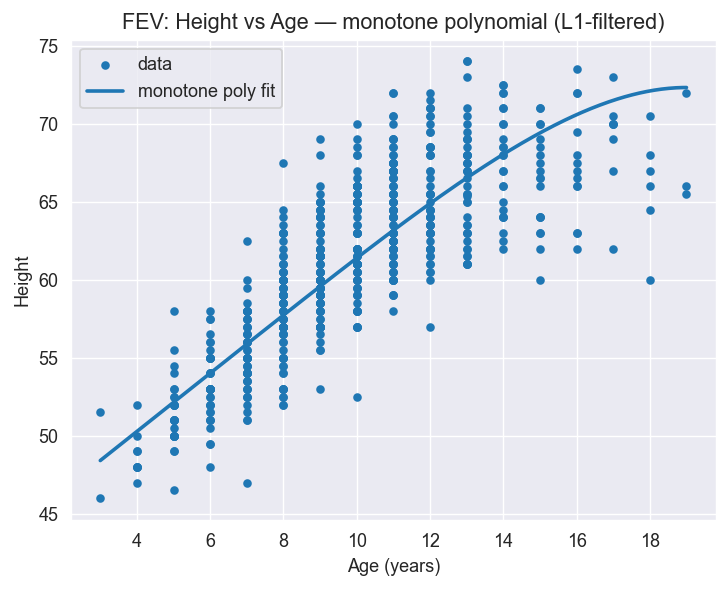

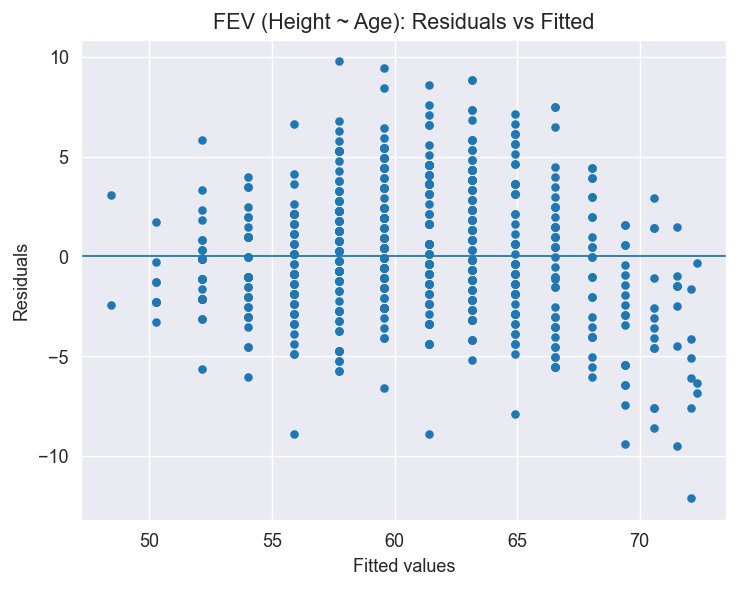

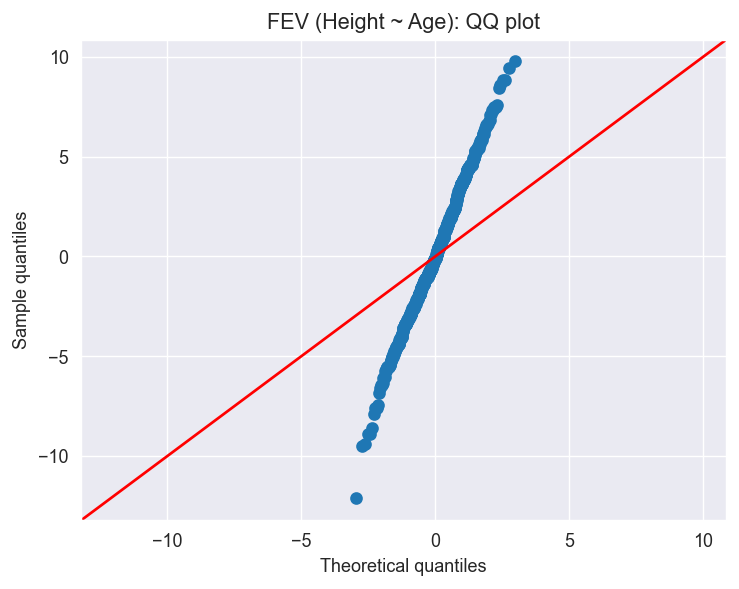

{'age_col': 'Age', 'height_col': 'Height', 'coef_t': array([48.420664  , 29.88957193,  0.        ,  0.        ,  0.        ,
       -5.97791419,  0.        ,  0.        ,  0.        ]), 'active_idx': [0, 1, 5], 'r2': 0.6580551155203095, 'rmse': 3.332638386534588, 'grid_deriv_min': 9.999999974752427e-07, 'age_minmax': (3.0, 19.0), 'poly_t': 'p(t) = 48.4207 + 29.8896·t + -5.97791·t^5,  где  t = (x - 3)/(19 - 3)', 'poly_x': 'p(x) = 42.8178 + 1.86579·x + 0.00153927·x^2 + -0.000513088·x^3 + 8.55147e-05·x^4 + -5.70098e-06·x^5'}


In [16]:
fev_path = "V1/fev.txt"

df = read_any(fev_path)

pick = fev_cv_pick_method(
    df,
    max_deg=8,
    cv=5,
    eps_mon=1e-6,
    l2_reg=1e-6,
    use_wls=True
)
print("CV RMSE:", pick["cv_rmse_by_method"], "→ best:", pick["best_method"])


res = fev_fit_monotone(
    df,
    max_deg=8,
    method=pick["best_method"],
    eps_mon=1e-6,
    out_dir="outputs",
    show_plots=True,
    save_plots=True
)
print(res) # костыль, тк иначе res отказывался выводиться...

## Task_2 V1


Выбрана модель: Log-log: log(time) ~ log(dist) + log(climb)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     69.15
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           2.42e-12
Time:                        06:12:56   Log-Likelihood:                -7.6567
No. Observations:                  35   AIC:                             21.31
Df Residuals:                      32   BIC:                             25.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

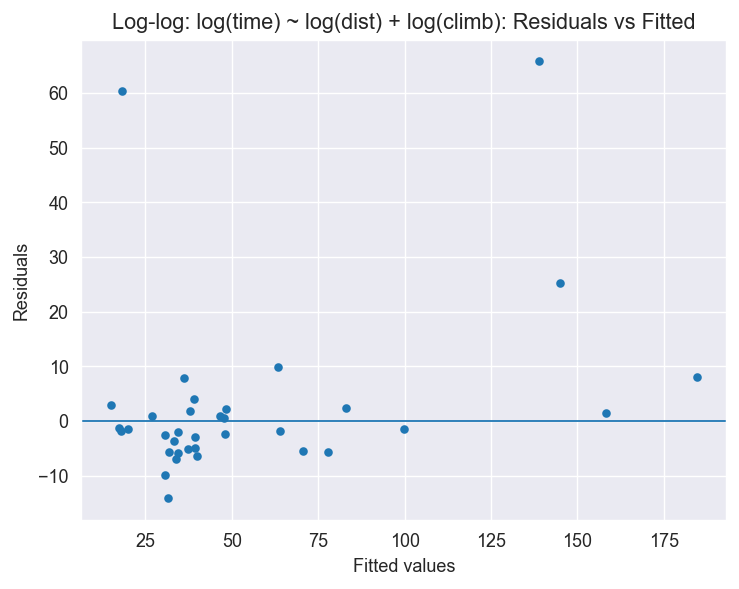

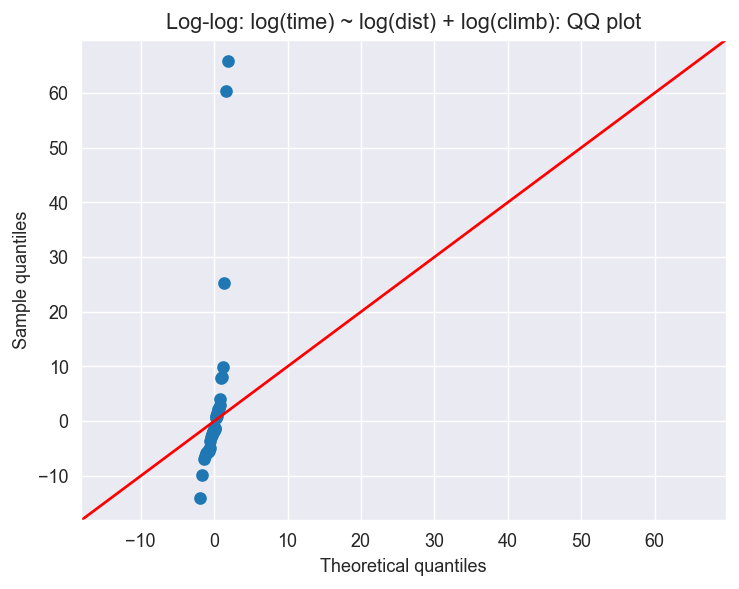


Breusch-Pagan: LM p-value=0.7172, F p-value=0.7358
Normality (Anderson–Darling) p-value=1.261e-12

Предпросмотр предсказаний:
   time  dist  climb      y_hat     resid
 16.083   2.5    650  17.273464 -1.190464
 48.350   6.0   2500  47.716372  0.633628
 33.650   6.0    900  40.067688 -6.417688
 45.600   7.5    800  47.976195 -2.376195
 62.267   8.0   3070  63.981667 -1.714667
 73.217   8.0   2866  63.233768  9.983232
204.617  16.0   7500 138.858234 65.758766
 36.367   6.0    800  39.268752 -2.901752
 29.750   5.0    800  33.341131 -3.591131
 39.750   6.0    650  37.898910  1.851090


In [22]:
df = read_any("V1/hills.txt")

y_cands = ["time", "result", "winner", "record"]
x1_cands = ["dist", "distance", "length", "miles", "km"]
x2_cands = ["climb", "height", "ascent", "elevation", "gain"]

y_col  = infer_col(df, y_cands)
d_col  = infer_col(df, x1_cands)
h_col  = infer_col(df, x2_cands)

if any(c is None for c in [y_col, d_col, h_col]):
    raise ValueError(
        f"Не нашёл столбцы. Нашёл: y={y_col}, dist={d_col}, climb={h_col}. "
        f"Колонки: {list(df.columns)}"
    )

use = df[[y_col, d_col, h_col]].apply(pd.to_numeric, errors="coerce").dropna()
use = use.rename(columns={y_col:"time", d_col:"dist", h_col:"climb"})

def fit_linear(u: pd.DataFrame):
    X = sm.add_constant(u[["dist", "climb"]])
    model = sm.OLS(u["time"], X).fit()
    yhat = model.predict(X)
    return {"name":"Linear: time ~ dist + climb",
            "model": model, "yhat": yhat, "aic": model.aic, "bic": model.bic}

def fit_loglog(u: pd.DataFrame):
    # Требуются положительные значения
    if (u[["time","dist","climb"]] <= 0).any().any():
        raise ValueError("Для log-log есть неположительные значения.")
    Z = pd.DataFrame({
        "const": 1.0,
        "log_dist": np.log(u["dist"].values),
        "log_climb": np.log(u["climb"].values),
    })
    model = sm.OLS(np.log(u["time"].values), Z).fit()
    # Прогноз в шкале времени: exp(E[log y | x])
    yhat = np.exp(model.predict(Z))
    return {"name":"Log-log: log(time) ~ log(dist) + log(climb)",
            "model": model, "yhat": yhat, "aic": model.aic, "bic": model.bic}

candidates = []
candidates.append(fit_linear(use))
try:
    candidates.append(fit_loglog(use))
except ValueError:
    pass

# Выбор по AIC
best = min(candidates, key=lambda r: r["aic"])

print("Выбрана модель:", best["name"])
print(best["model"].summary())

# Диагностика остатков и базовые тесты
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
y_true = use["time"].values
y_pred = best["yhat"].values
resid = y_true - y_pred

# Графики остатков + QQ
plot_residuals(y_true, y_pred, title=best["name"], save_prefix="out/hills")

# Тест Бройша—Пагана на гетероскедастичность
# Для регрессоров берём те, что были в модели
if "Log-log" in best["name"]:
    exog = pd.DataFrame({"const":1.0,
                         "log_dist":np.log(use["dist"].values),
                         "log_climb":np.log(use["climb"].values)})
else:
    exog = sm.add_constant(use[["dist","climb"]])

bp_lm, bp_lm_p, fval, f_p = het_breuschpagan(resid, exog)
print(f"\nBreusch-Pagan: LM p-value={bp_lm_p:.4g}, F p-value={f_p:.4g}")

# Нормальность остатков (Anderson–Darling)
ad_stat, ad_p = normal_ad(resid)
print(f"Normality (Anderson–Darling) p-value={ad_p:.4g}")

# 5) Пример прогноза для исходных строк
out = use.copy()
out["y_hat"] = y_pred
out["resid"] = resid
print("\nПредпросмотр предсказаний:")
print(out.head(10).to_string(index=False))

# 6) Сохранение результатов
Path("out").mkdir(exist_ok=True, parents=True)
out.to_csv("out/hills_predictions.csv", index=False)
with open("out/hills_model.txt","w",encoding="utf-8") as f:
    f.write("Chosen model: " + best["name"] + "\n\n")
    f.write(str(best["model"].summary()))
    f.write("\n\nBreusch-Pagan p=" + f"{bp_lm_p:.6g}")
    f.write("\nAnderson-Darling p=" + f"{ad_p:.6g}" )

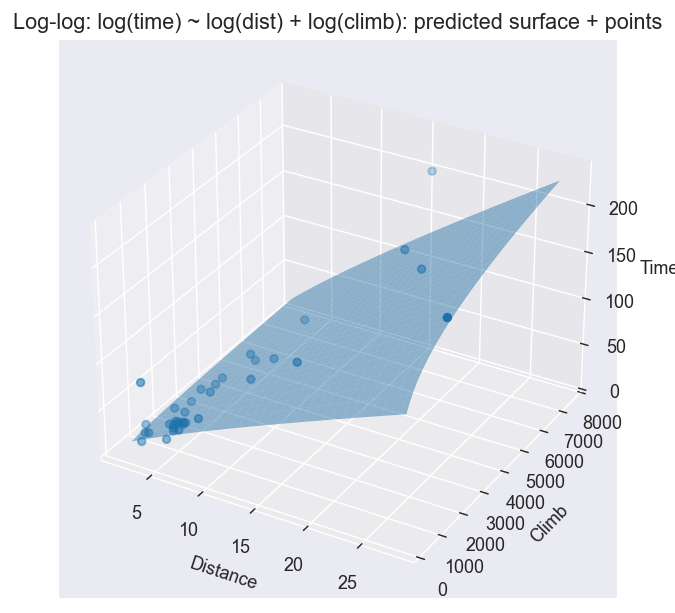

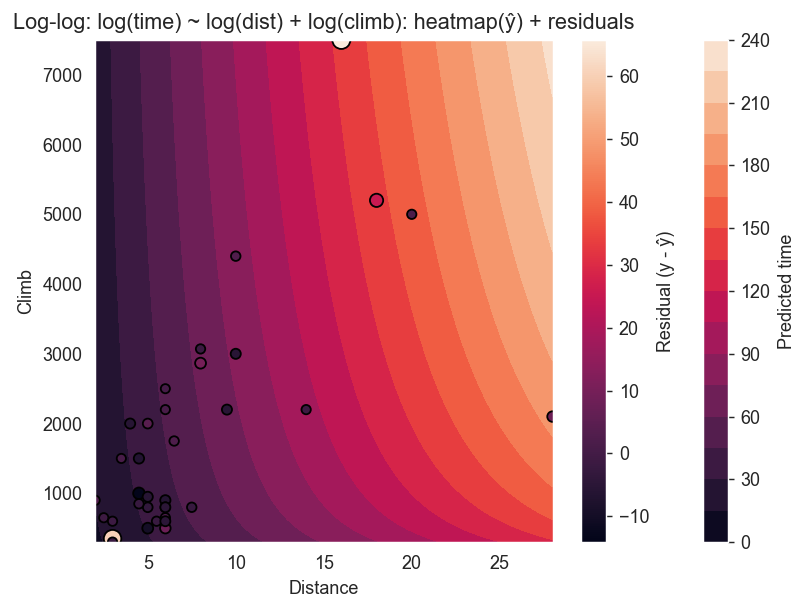

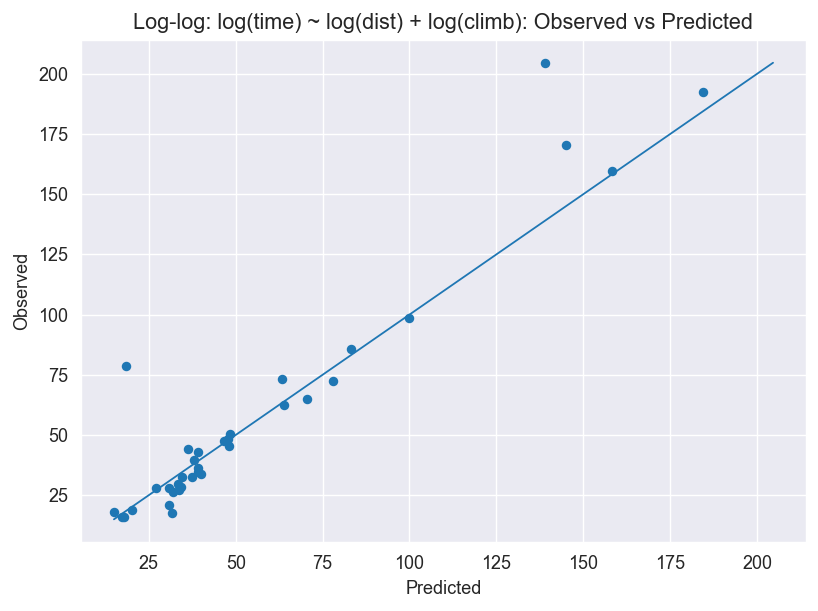

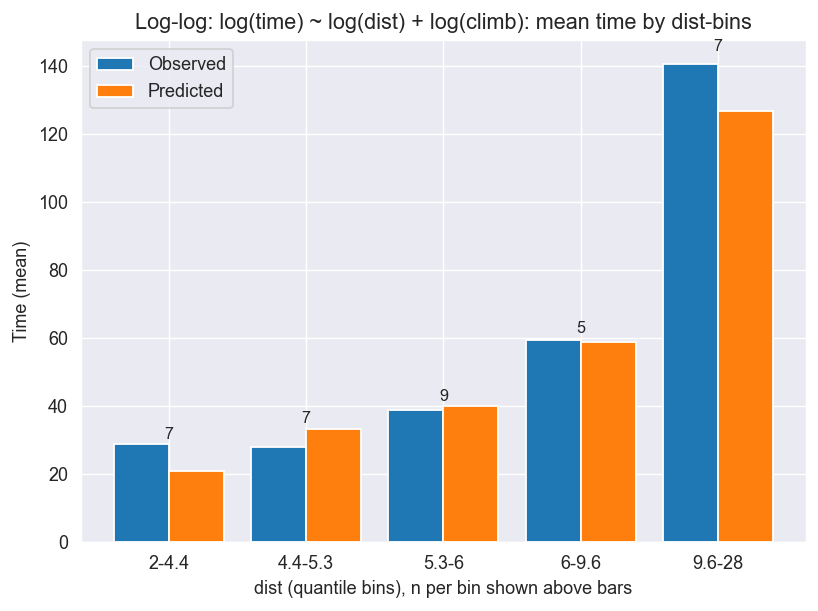

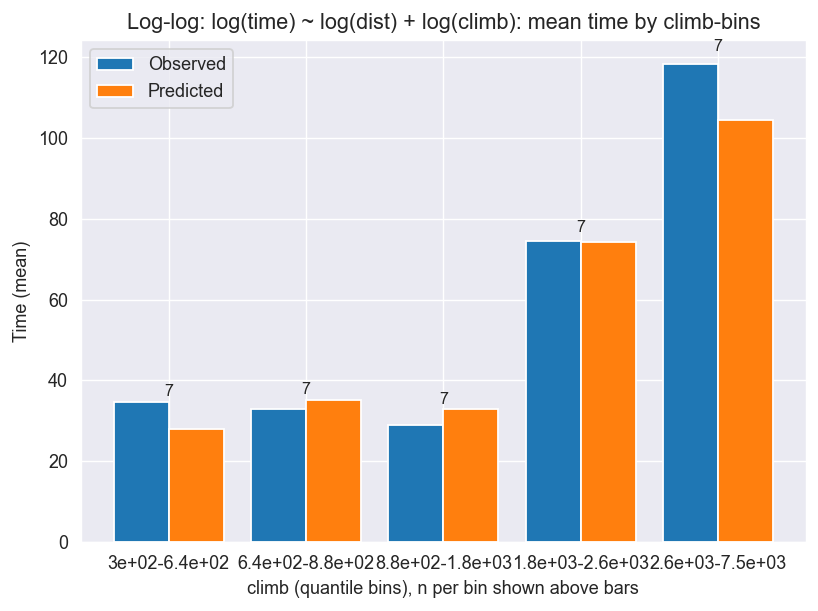

In [21]:
Path("out").mkdir(parents=True, exist_ok=True)

def _make_predictor(best_model_dict):
    name = best_model_dict["name"]
    params = best_model_dict["model"].params

    if "Log-log" in name:
        c  = params.get("const", params.iloc[0])
        b1 = params.get("log_dist", params.iloc[1])
        b2 = params.get("log_climb", params.iloc[2])

        def predict_fn(dist, climb):
            dist = np.asarray(dist)
            climb = np.asarray(climb)
            dist = np.clip(dist, 1e-12, None)
            climb = np.clip(climb, 1e-12, None)
            return np.exp(c + b1*np.log(dist) + b2*np.log(climb))
    else:
        c  = params.get("const", params.iloc[0])
        b1 = params.get("dist",  params.iloc[1])
        b2 = params.get("climb", params.iloc[2])

        def predict_fn(dist, climb):
            dist = np.asarray(dist)
            climb = np.asarray(climb)
            return c + b1*dist + b2*climb

    return predict_fn, name

def plot_surface_3d(use, predict_fn, title, grid_res=60, save_prefix="out/hills_surface3d"):
    d_min, d_max = use["dist"].min(), use["dist"].max()
    h_min, h_max = use["climb"].min(), use["climb"].max()
    D = np.linspace(d_min, d_max, grid_res)
    H = np.linspace(h_min, h_max, grid_res)
    DD, HH = np.meshgrid(D, H)
    ZZ = predict_fn(DD, HH)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(DD, HH, ZZ, alpha=0.45, linewidth=0)
    ax.scatter(use["dist"], use["climb"], use["time"], s=18)
    ax.set_xlabel("Distance")
    ax.set_ylabel("Climb")
    ax.set_zlabel("Time")
    ax.set_title(f"{title}: predicted surface + points")
    fig.tight_layout()
    fig.savefig(f"{save_prefix}.png", dpi=130, bbox_inches="tight")
    plt.show()

def plot_heatmap_with_residuals(use, predict_fn, title, grid_res=250, save_prefix="out/hills_heat"):
    d_min, d_max = use["dist"].min(), use["dist"].max()
    h_min, h_max = use["climb"].min(), use["climb"].max()
    D = np.linspace(d_min, d_max, grid_res)
    H = np.linspace(h_min, h_max, grid_res)
    DD, HH = np.meshgrid(D, H)
    Z = predict_fn(DD, HH)

    # heatmap of prediction
    fig, ax = plt.subplots()
    cs = ax.contourf(DD, HH, Z, levels=20)
    cb = fig.colorbar(cs, ax=ax)
    cb.set_label("Predicted time")

    
    yhat_pts = predict_fn(use["dist"].values, use["climb"].values)
    resid_pts = use["time"].values - yhat_pts
    sizes = 25 + 75*(np.abs(resid_pts) / (np.abs(resid_pts).max() + 1e-12))
    sc = ax.scatter(use["dist"], use["climb"], c=resid_pts, s=sizes, edgecolor="k")
    cbr = fig.colorbar(sc, ax=ax)
    cbr.set_label("Residual (y - ŷ)")

    ax.set_xlabel("Distance")
    ax.set_ylabel("Climb")
    ax.set_title(f"{title}: heatmap(ŷ) + residuals")
    fig.tight_layout()
    fig.savefig(f"{save_prefix}.png", dpi=130, bbox_inches="tight")
    plt.show()

def plot_obs_vs_pred(y_true, y_pred, title, save_prefix="out/hills_obs_vs_pred"):
    fig = plt.figure()
    plt.scatter(y_pred, y_true, s=18)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, lw=1) 
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.title(f"{title}: Observed vs Predicted")
    fig.tight_layout()
    fig.savefig(f"{save_prefix}.png", dpi=130, bbox_inches="tight")
    plt.show()

def plot_binned_bars(use, y_pred, by="dist", bins=5, save_prefix="out/hills_bars"):
    dfb = use.copy()
    dfb["yhat"] = y_pred
    cats = pd.qcut(dfb[by], q=bins, duplicates="drop")
    g = dfb.groupby(cats, observed=True).agg(time_mean=("time","mean"),
                                         yhat_mean=("yhat","mean"),
                                         n=("time","size"))
    idx = np.arange(len(g))
    width = 0.4

    fig, ax = plt.subplots()
    ax.bar(idx - width/2, g["time_mean"].values, width, label="Observed")
    ax.bar(idx + width/2, g["yhat_mean"].values, width, label="Predicted")
    ax.set_xticks(idx)
    ax.set_xticklabels([f"{iv.left:.2g}-{iv.right:.2g}" for iv in g.index])
    ax.set_xlabel(f"{by} (quantile bins), n per bin shown above bars")
    ax.set_ylabel("Time (mean)")
    ax.set_title(f"{best['name']}: mean time by {by}-bins")
    for i, n in enumerate(g["n"].values):
        ax.text(i, max(g["time_mean"].iloc[i], g["yhat_mean"].iloc[i])*1.02, str(n),
                ha="center", va="bottom", fontsize=9)
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"{save_prefix}_{by}.png", dpi=130, bbox_inches="tight")
    plt.show()


predict_fn, title = _make_predictor(best)
plot_surface_3d(use, predict_fn, title, save_prefix="out/hills_surface3d")
plot_heatmap_with_residuals(use, predict_fn, title, save_prefix="out/hills_heat")
plot_obs_vs_pred(use["time"].values, y_pred, title, save_prefix="out/hills_obs_vs_pred")
plot_binned_bars(use, y_pred, by="dist", bins=5, save_prefix="out/hills_bars")
plot_binned_bars(use, y_pred, by="climb", bins=5, save_prefix="out/hills_bars")

## Task_3 V1


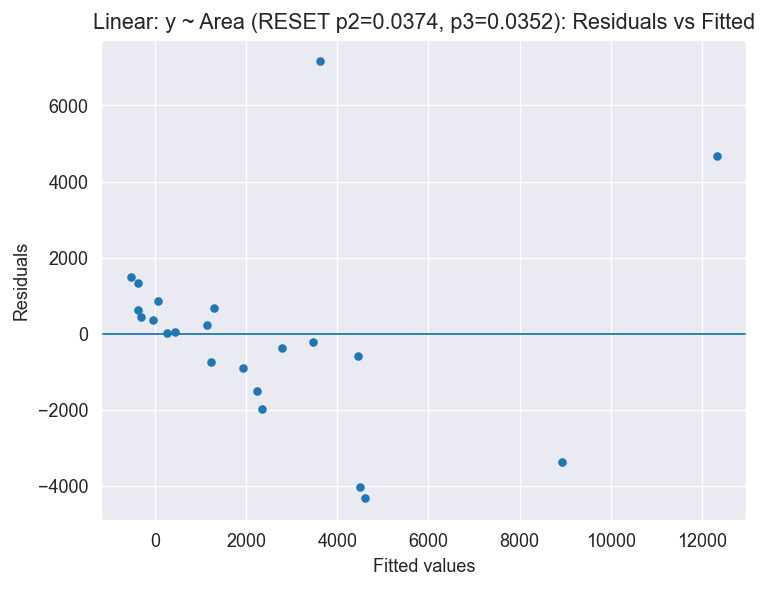

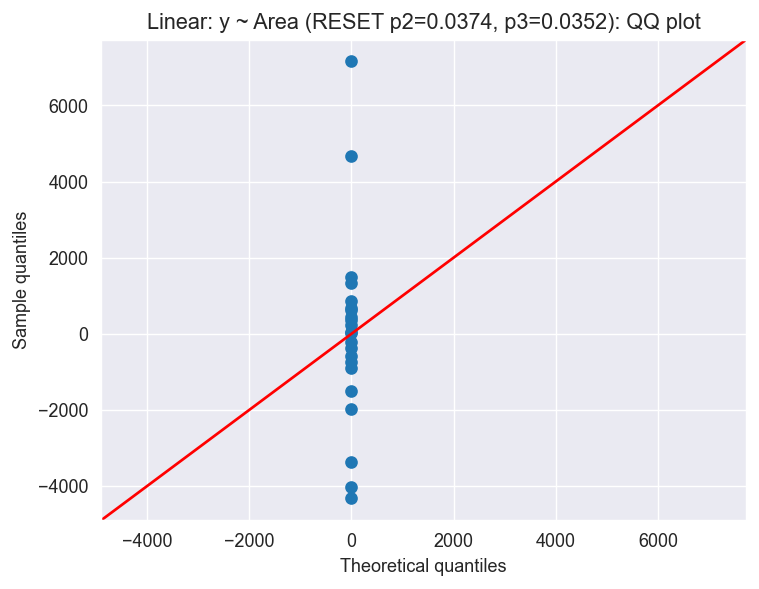

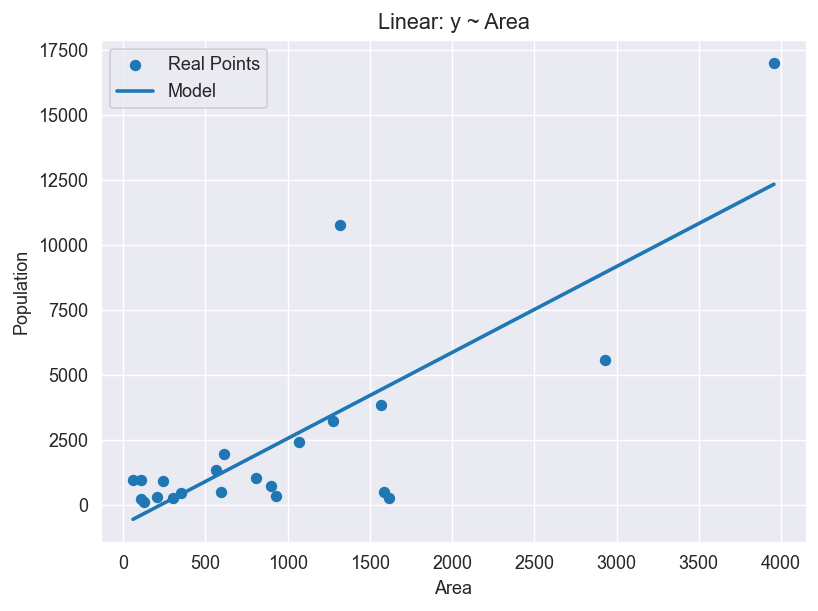

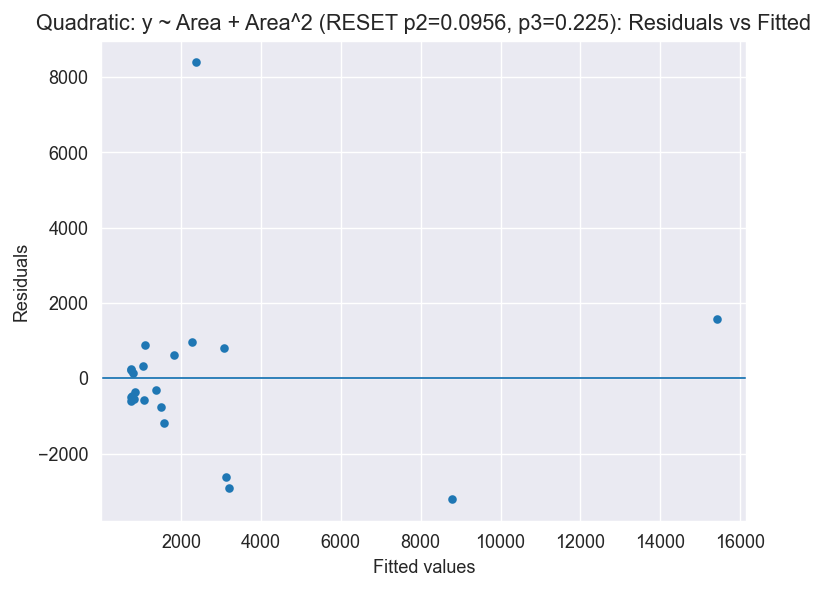

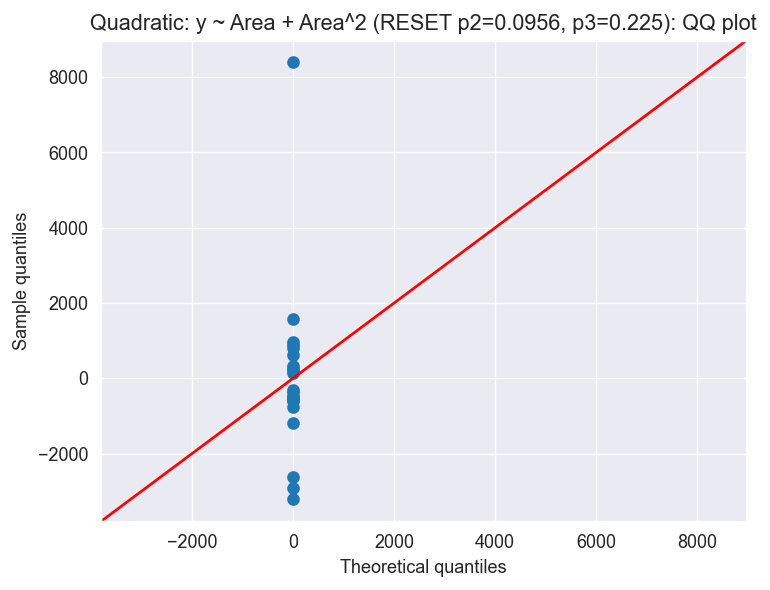

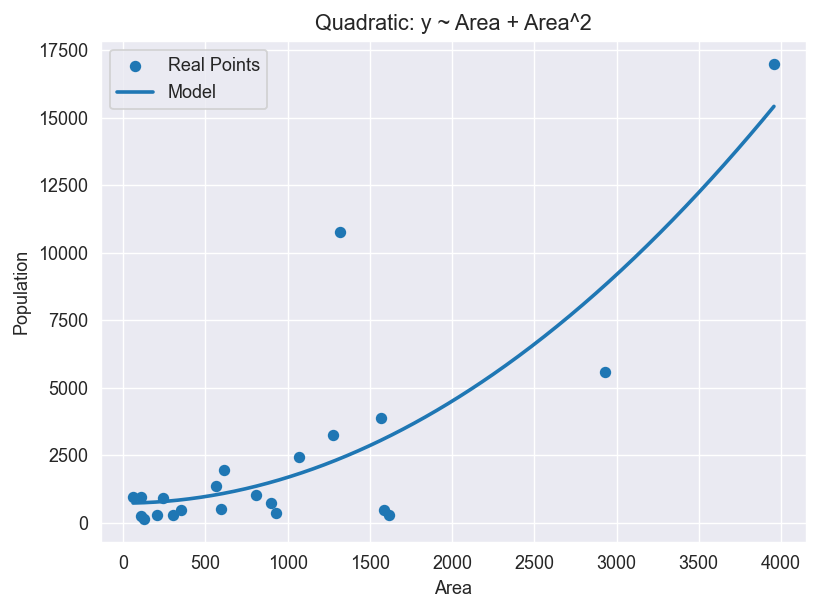

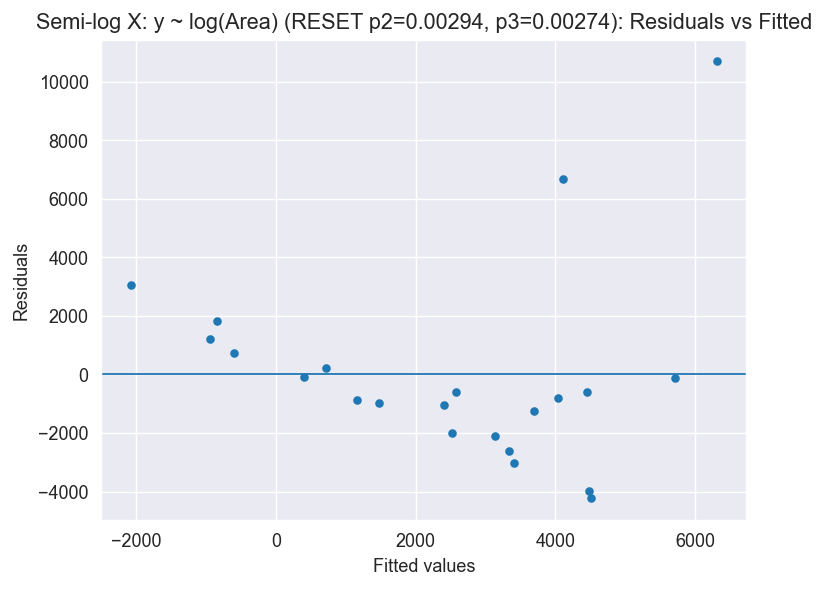

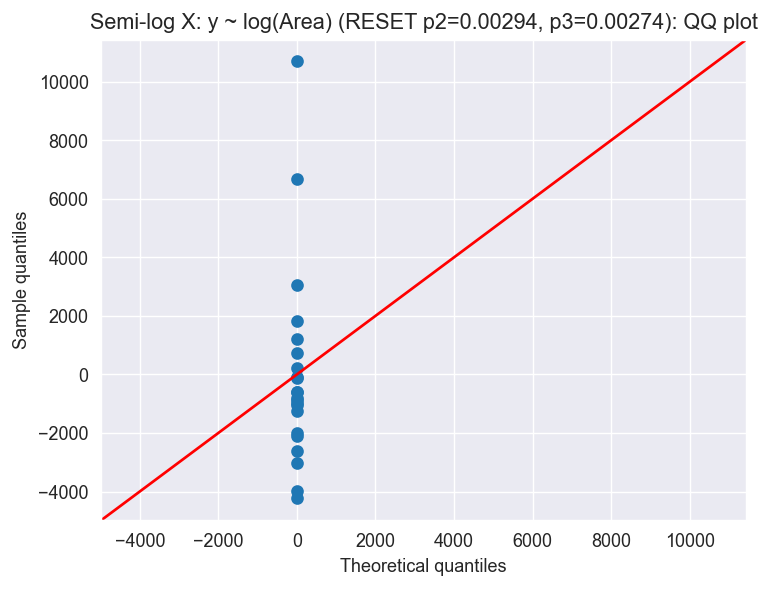

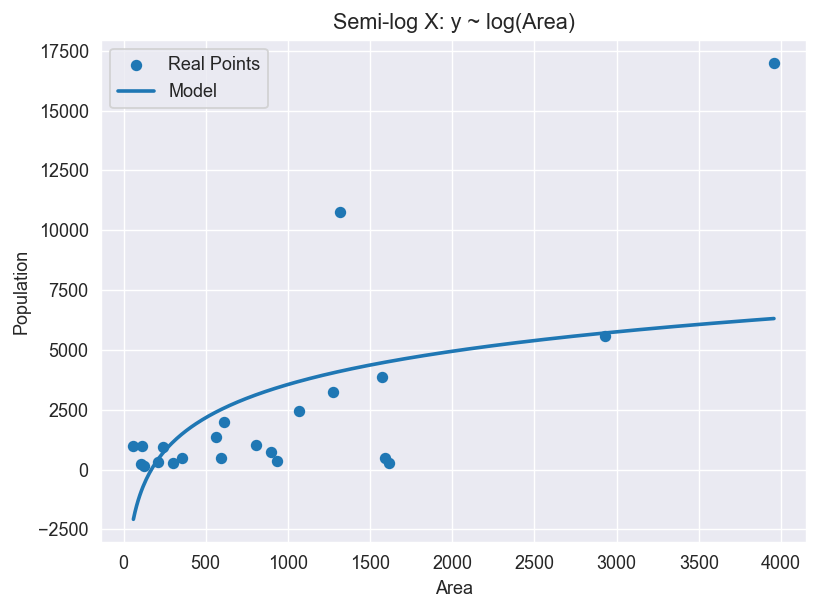

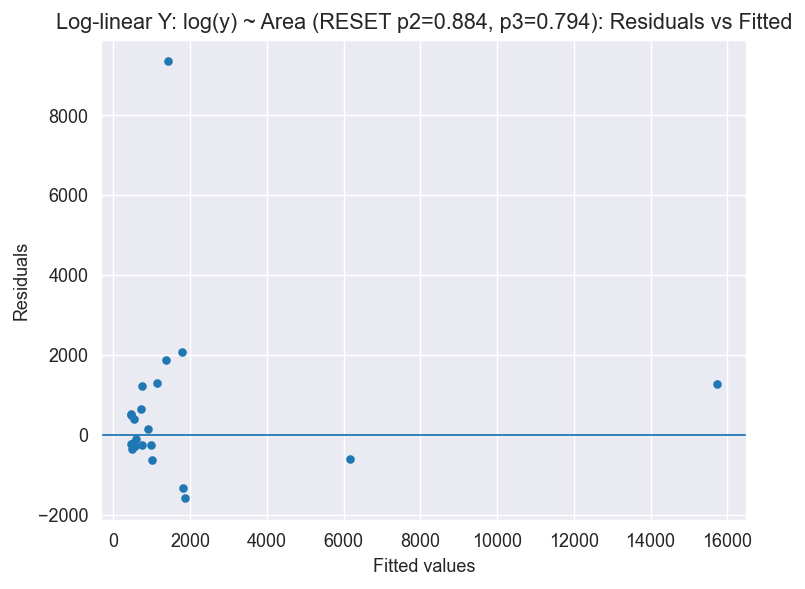

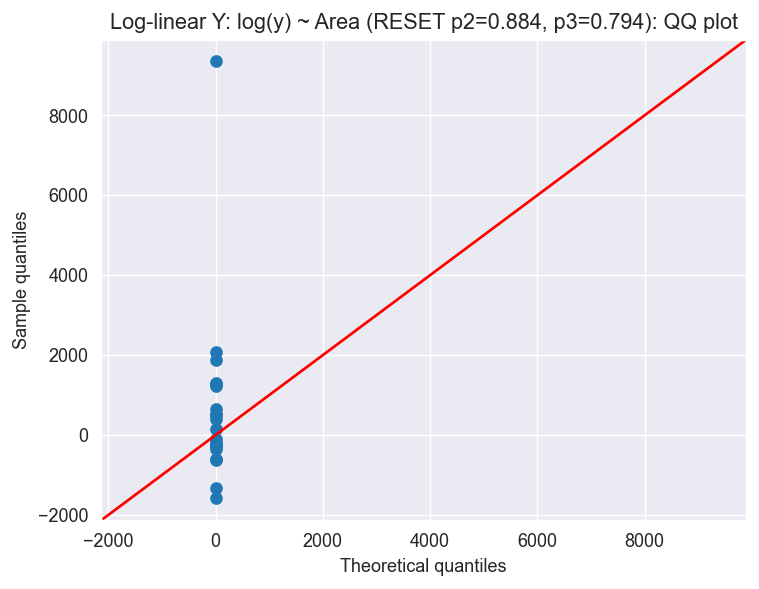

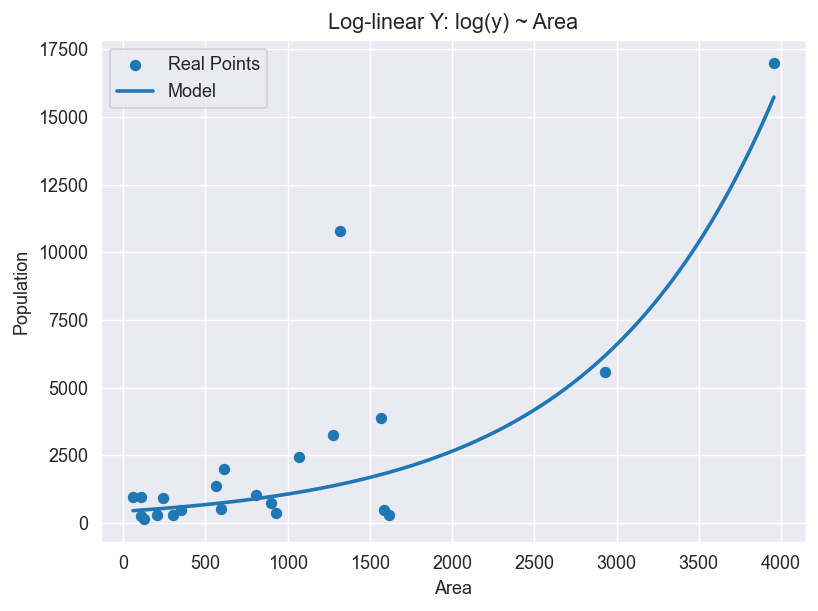

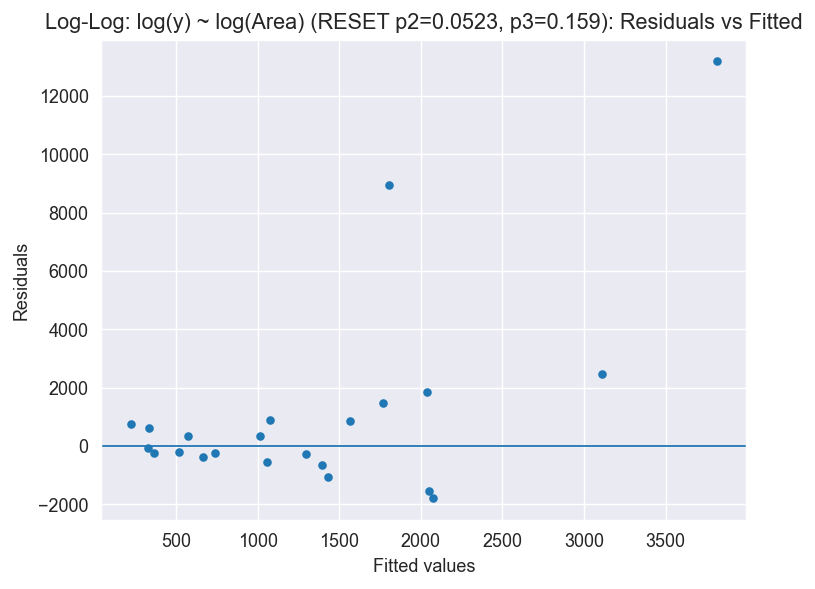

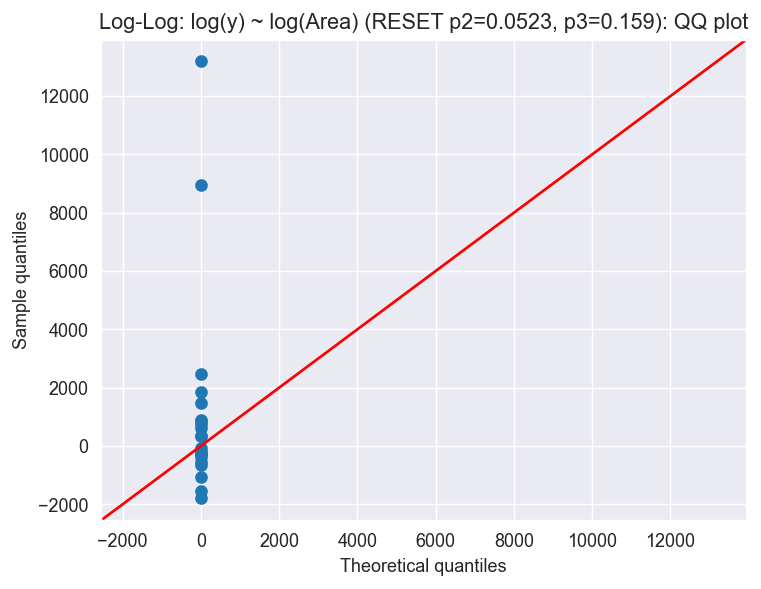

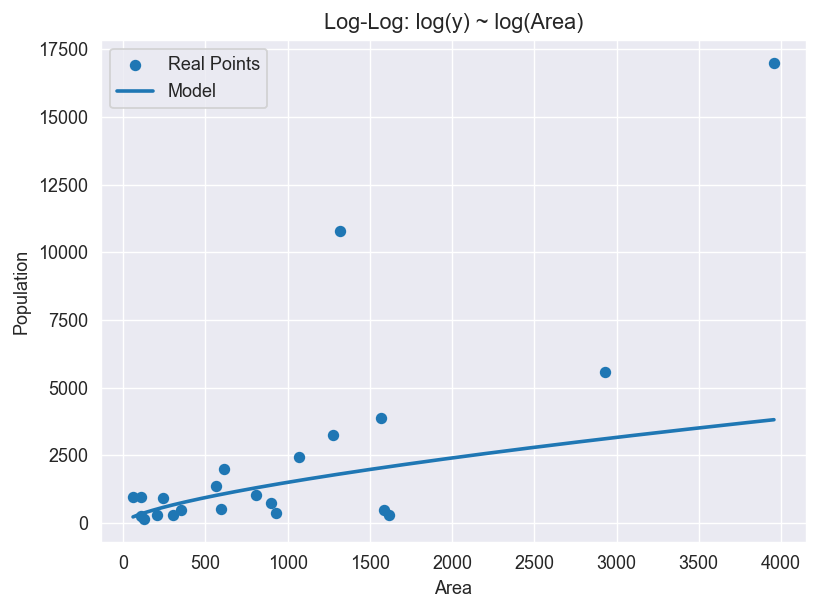

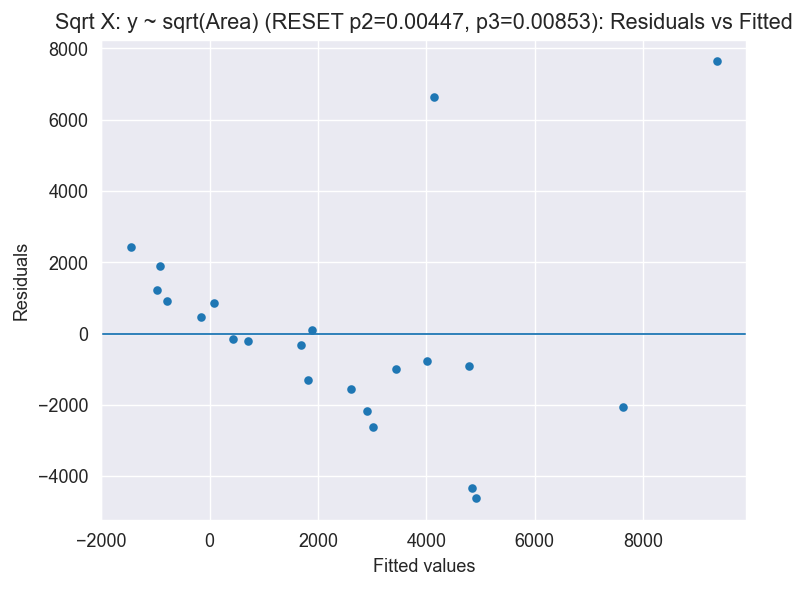

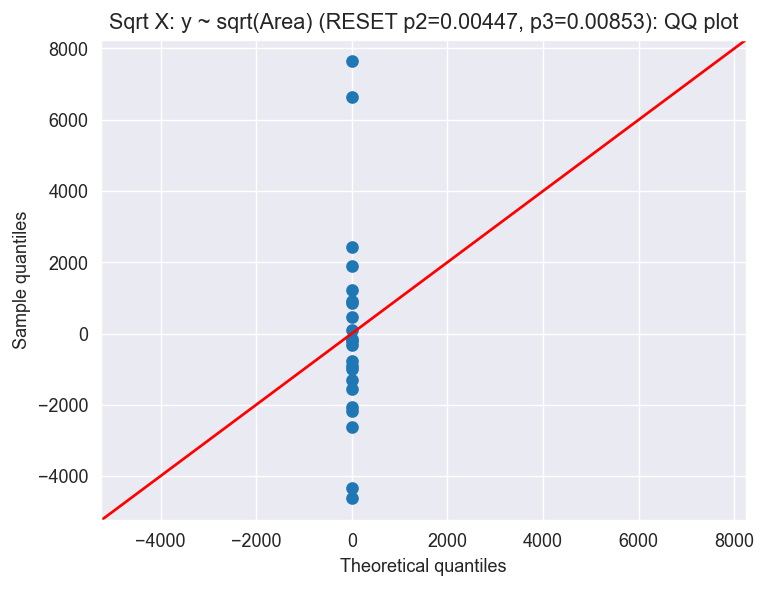

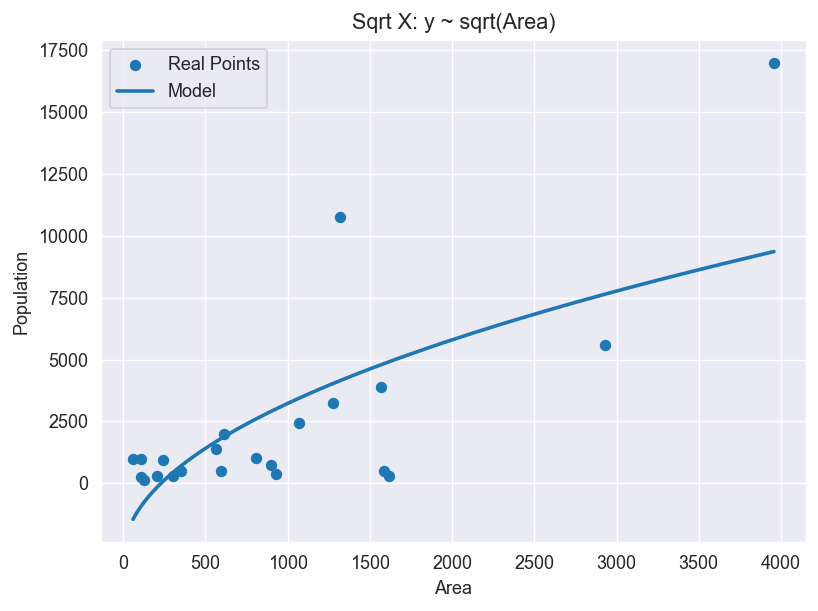


Сравнение моделей:
                       model  n        AIC        BIC  R2(transf.)  RESET p (pow=2)  RESET p (pow=3)                                                                               sm_res
 Log-linear Y: log(y) ~ Area 22  62.130624  64.312709     0.472522         0.883862         0.793504 <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x16b1371d0>
 Log-Log: log(y) ~ log(Area) 22  66.232036  68.414121     0.364422         0.052296         0.158683 <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x169b08110>
Quadratic: y ~ Area + Area^2 22 406.819994 410.093121     0.695965         0.095589         0.225220 <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x168fcf020>
            Linear: y ~ Area 22 409.967853 412.149938     0.615811         0.037386         0.035162 <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x169a7c200>
      Sqrt X: y ~ sqrt(Area) 22 416.358922 418.541

In [26]:
Path("out").mkdir(parents=True, exist_ok=True)

df = read_any("V1/Kittiwake.txt")
x_col = infer_col(df, ["area"])
y_col = infer_col(df, ["population"])


data = df[[x_col, y_col]].apply(pd.to_numeric, errors="coerce").dropna()
data = data.rename(columns={x_col:"Area", y_col:"Population"})

#  Utils
def _safe_log(v):
    v = np.asarray(v, dtype=float)
    if np.any(v <= 0):
        raise ValueError("needed for log() x>0.")
    return np.log(v)

def _safe_sqrt(v):
    v = np.asarray(v, dtype=float)
    if np.any(v < 0):
        raise ValueError("sqrt needs x>=0.")
    return np.sqrt(v)

def _reset_p(model_res, power):
    r = linear_reset(model_res, power=power, use_f=True)
    try:
        return float(r.pvalue)
    except Exception:
        return float(r[1])

def _slug(s): 
    return s.replace(" ", "_").replace("~","").replace("/","_")

def fit_and_plot(name, y_tf=None, inv_y=None, x_tf=None, add_quad=False, save_prefix="out/kittiwake_simple"):
    x = data["Area"].values
    y = data["Population"].values

    # transformation mask
    mask = np.isfinite(x) & np.isfinite(y)
    if x_tf is _safe_log:   mask &= x > 0
    if y_tf is _safe_log:   mask &= y > 0
    if x_tf is _safe_sqrt:  mask &= x >= 0

    x = x[mask]; y = y[mask]

    y_t = y_tf(y) if y_tf else y
    x1  = x_tf(x) if x_tf else x

    X = np.column_stack([x1, x1**2]) if add_quad else np.column_stack([x1])
    X = sm.add_constant(X, has_constant="add")

    res = sm.OLS(y_t, X).fit()

    def predict_fn(x_new):
        xx = np.asarray(x_new, dtype=float)
        zz = x_tf(xx) if x_tf else xx
        Xp = np.column_stack([zz, zz**2]) if add_quad else np.column_stack([zz])
        Xp = sm.add_constant(Xp, has_constant="add")
        yhat_t = res.predict(Xp)
        return inv_y(yhat_t) if inv_y else yhat_t

    y_hat = predict_fn(x)

    # RESET
    p2 = _reset_p(res, power=2)
    p3 = _reset_p(res, power=3)


    plot_residuals(y_true=y, y_pred=y_hat,
                   title=f"{name} (RESET p2={p2:.3g}, p3={p3:.3g})",
                   save_prefix=f"{save_prefix}_{_slug(name)}")


    xs = np.linspace(x.min(), x.max(), 400)
    ys = predict_fn(xs)
    fig = plt.figure()
    plt.scatter(x, y, s=28, label="Real Points")
    plt.plot(xs, ys, lw=2, label="Model")
    plt.xlabel("Area")
    plt.ylabel("Population")
    plt.title(name)
    plt.legend()
    fig.tight_layout()
    fig.savefig(f"{save_prefix}_{_slug(name)}_scatter_fit.png", dpi=130, bbox_inches="tight")
    plt.show()

    return {
        "model": name,
        "n": len(y),
        "AIC": res.aic,
        "BIC": res.bic,
        "R2(transf.)": res.rsquared,
        "RESET p (pow=2)": p2,
        "RESET p (pow=3)": p3,
        "sm_res": res
    }

# 3) Models
results = []
results.append(fit_and_plot("Linear: y ~ Area"))
results.append(fit_and_plot("Quadratic: y ~ Area + Area^2", add_quad=True))
try:
    results.append(fit_and_plot("Semi-log X: y ~ log(Area)", x_tf=_safe_log))
except ValueError as e:
    print("Semi-log X skipped:", e)
try:
    results.append(fit_and_plot("Log-linear Y: log(y) ~ Area", y_tf=_safe_log, inv_y=np.exp))
except ValueError as e:
    print("Log-linear Y skipped:", e)
try:
    results.append(fit_and_plot("Log-Log: log(y) ~ log(Area)", y_tf=_safe_log, inv_y=np.exp, x_tf=_safe_log))
except ValueError as e:
    print("Log-Log skipped:", e)
try:
    results.append(fit_and_plot("Sqrt X: y ~ sqrt(Area)", x_tf=_safe_sqrt))
except ValueError as e:
    print("Sqrt X skipped:", e)

# 4) Res
tbl = pd.DataFrame(results).sort_values("AIC")
print("\nСравнение моделей:")
print(tbl.to_string(index=False))
tbl.to_csv("out/kittiwake_simple_models_summary.csv", index=False)

# Top-3 summary()
with open("out/kittiwake_simple_top3.txt","w",encoding="utf-8") as f:
    for name in tbl.head(3)["model"]:
        r = next(m for m in results if m["model"] == name)
        f.write("="*80 + "\n" + name + "\n" + "="*80 + "\n")
        f.write(str(r["sm_res"].summary()) + "\n\n")

## Task_4 V1


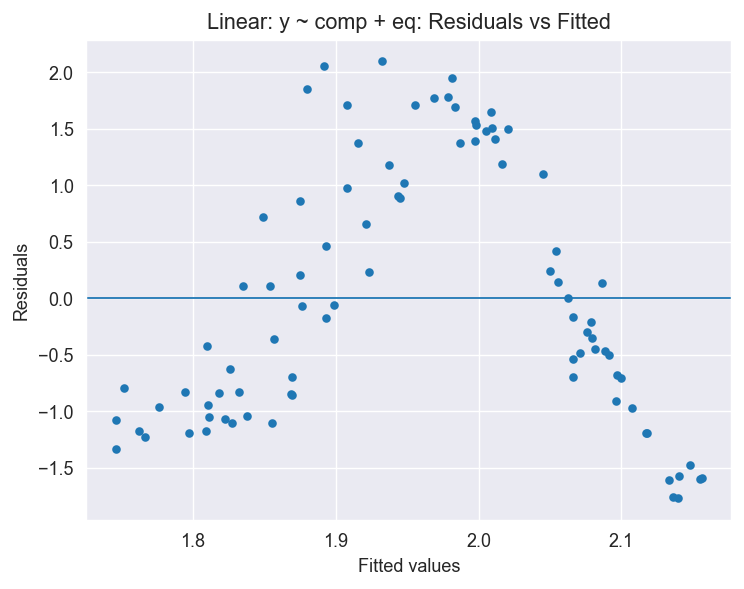

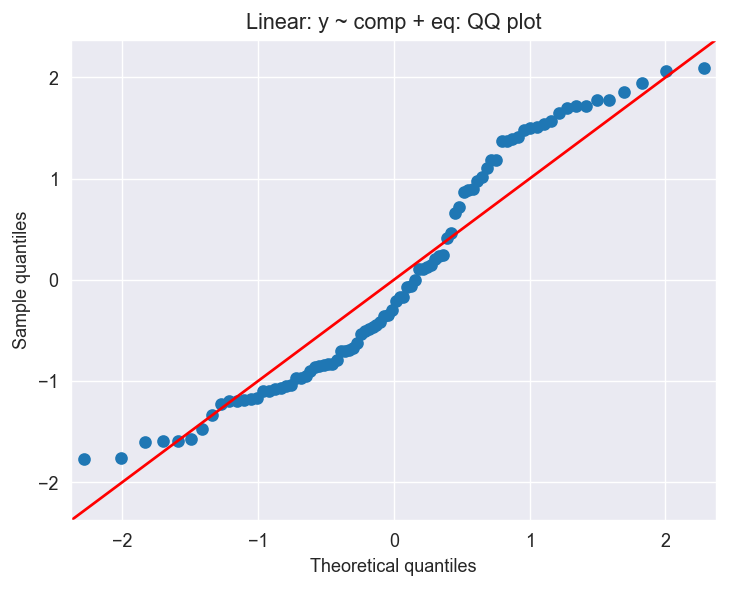

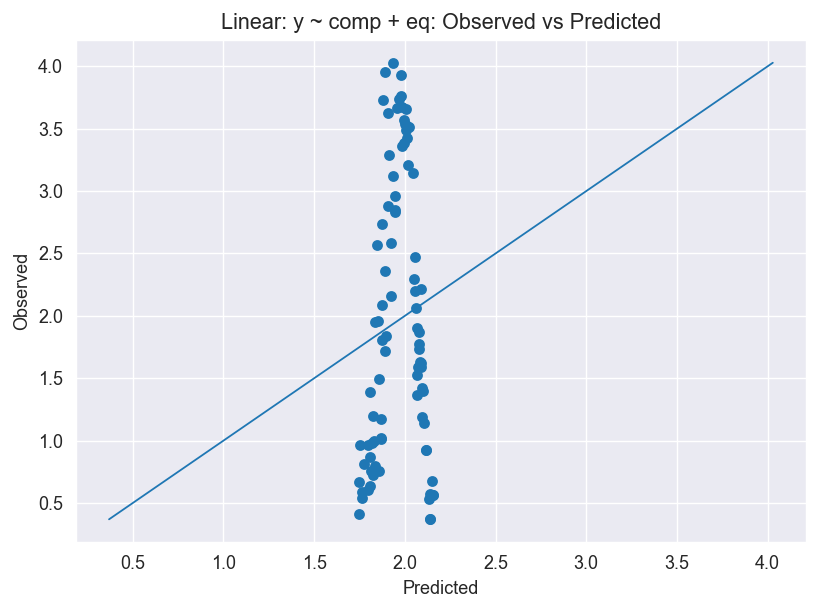

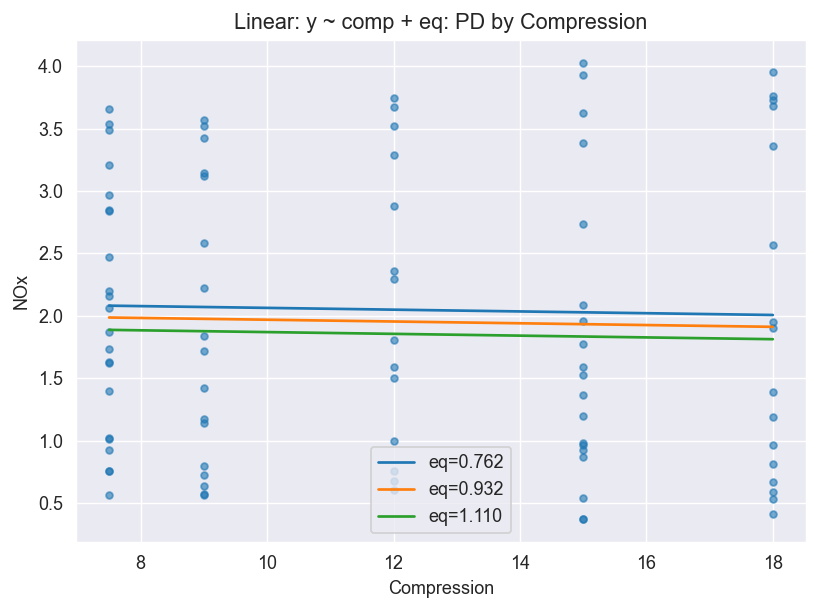

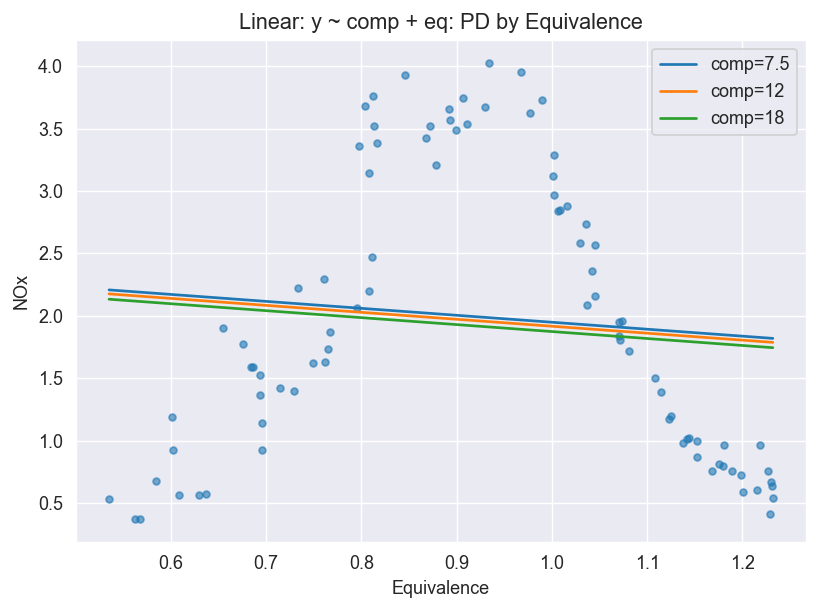

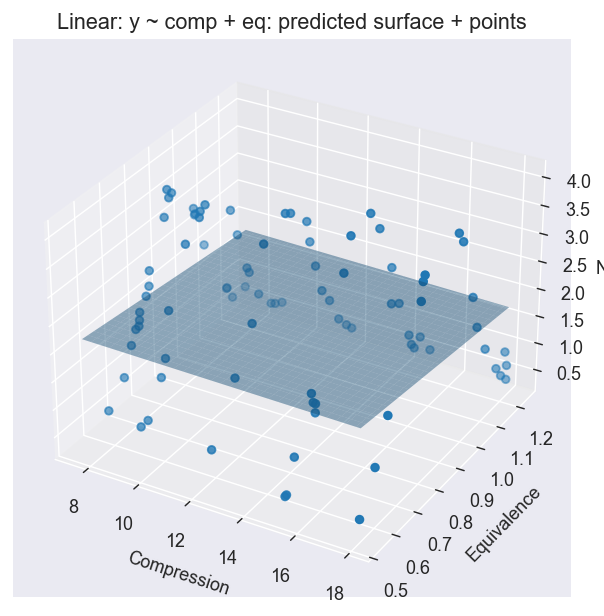

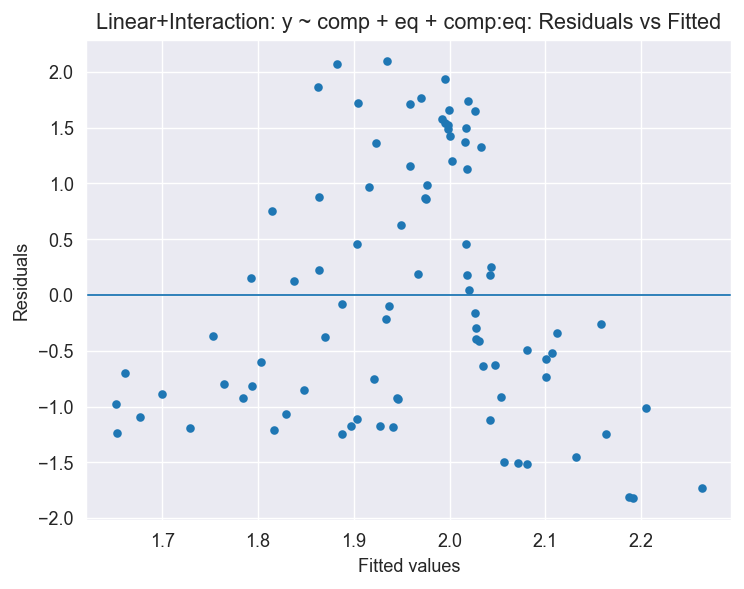

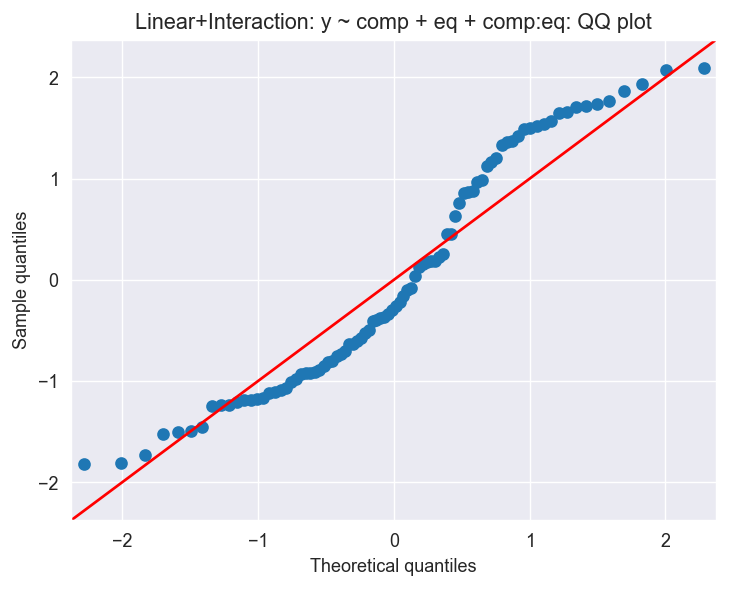

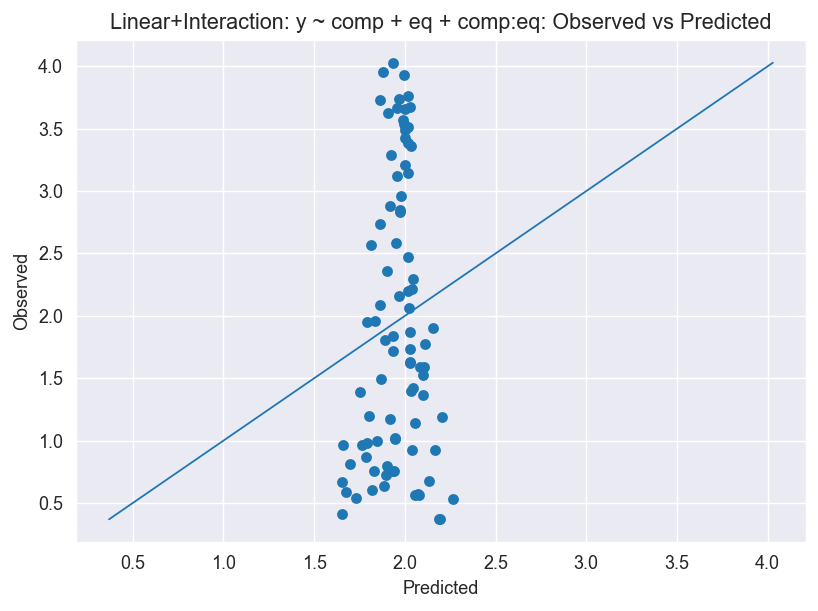

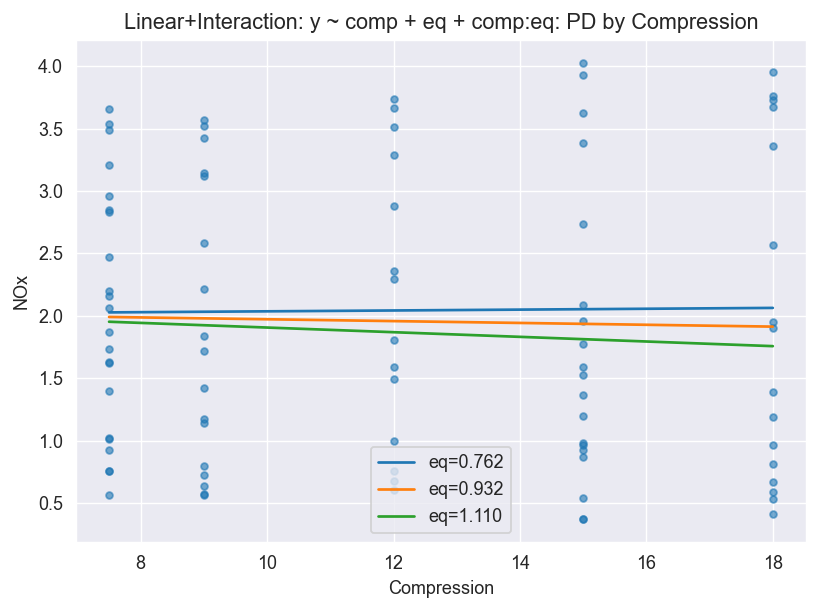

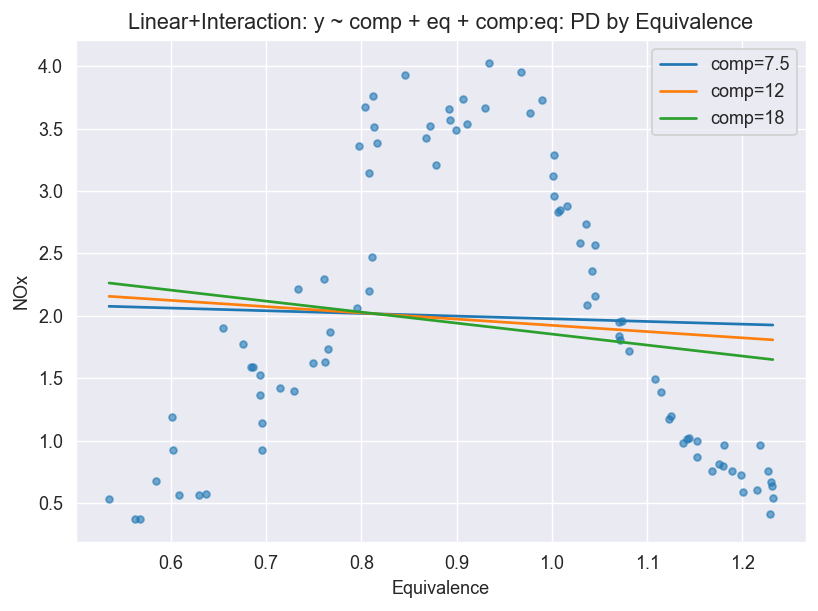

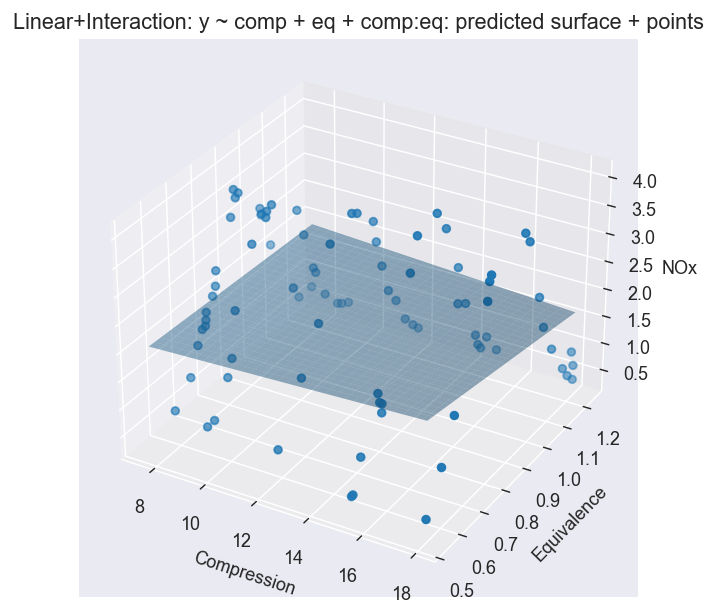

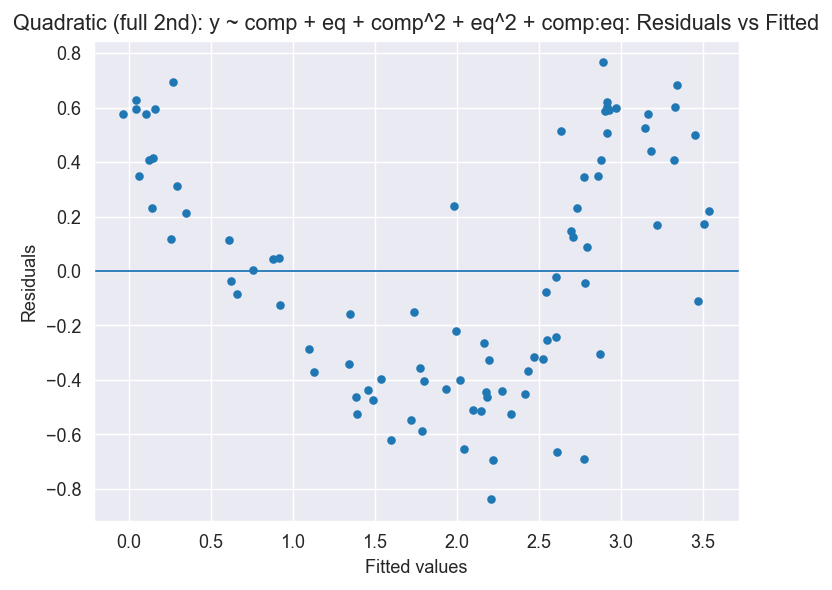

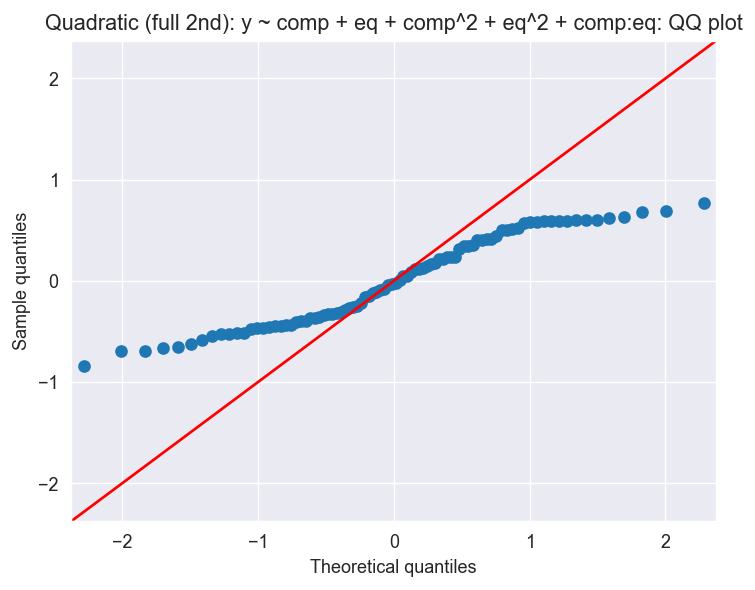

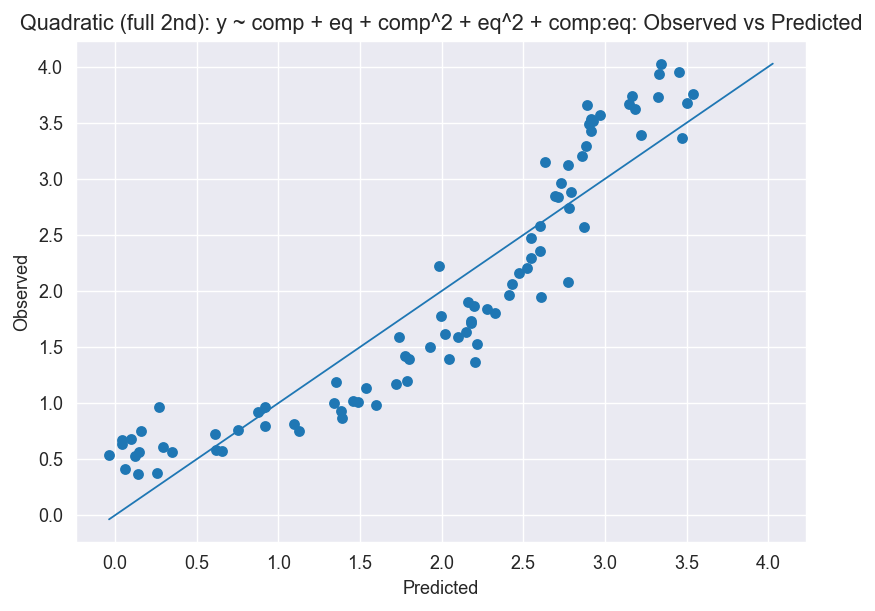

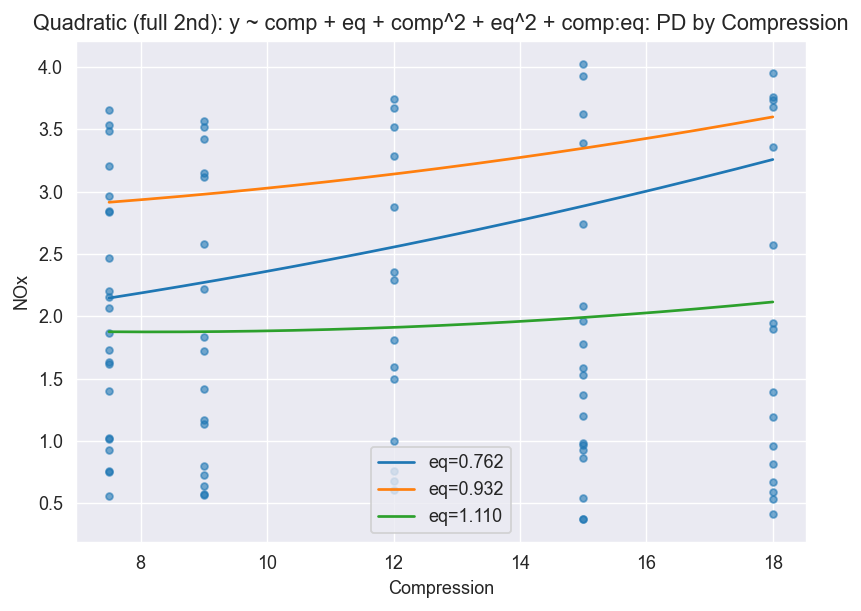

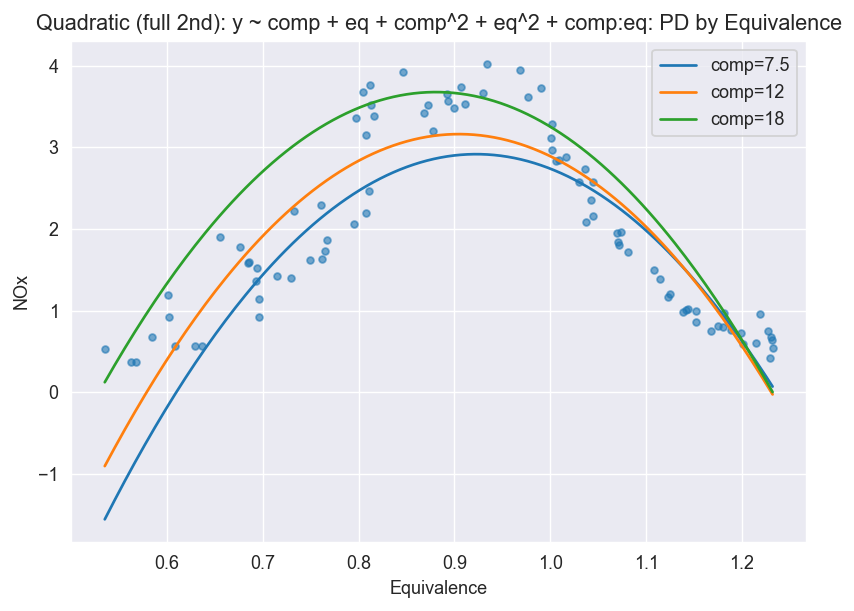

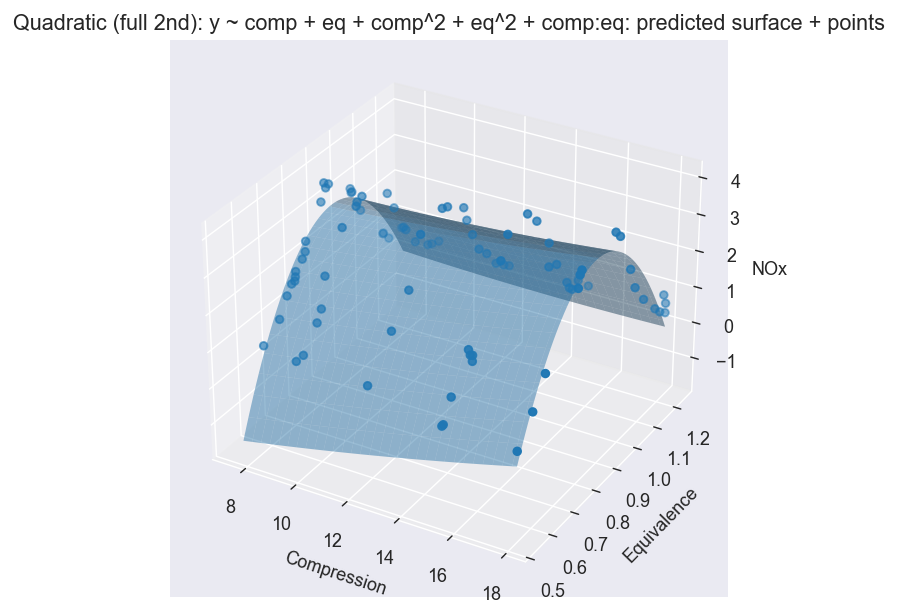

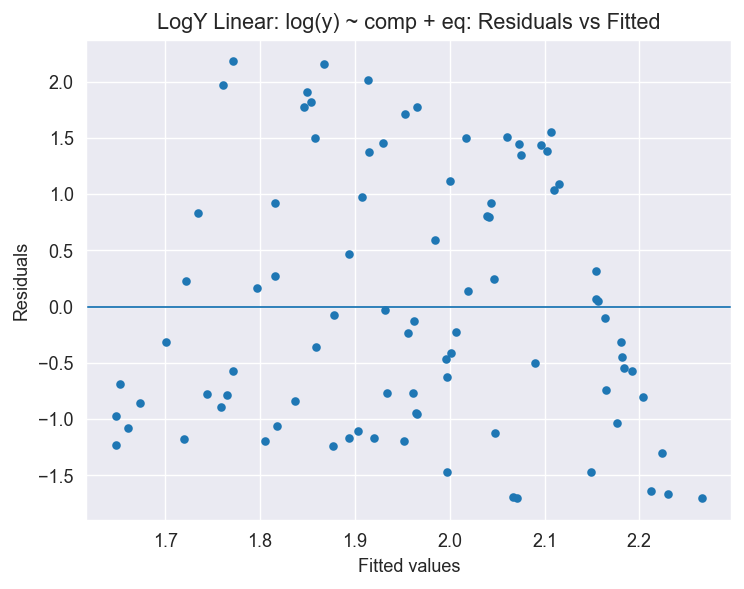

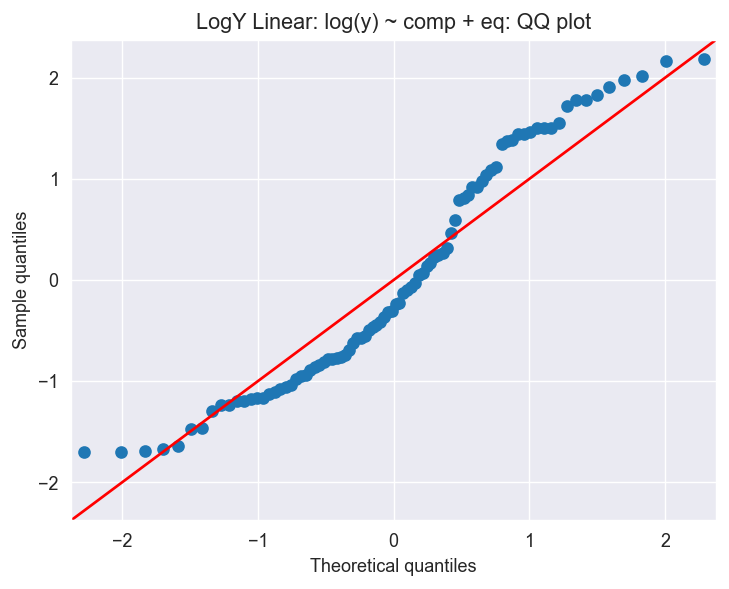

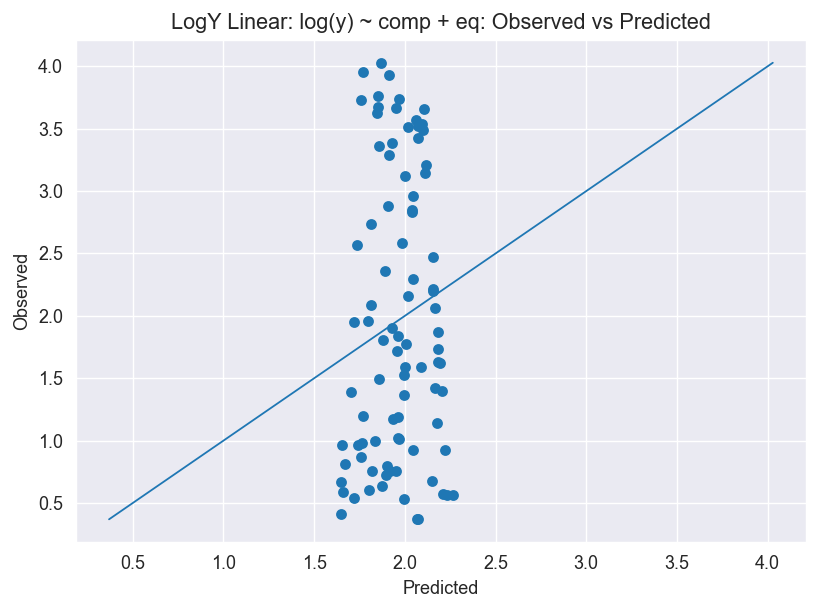

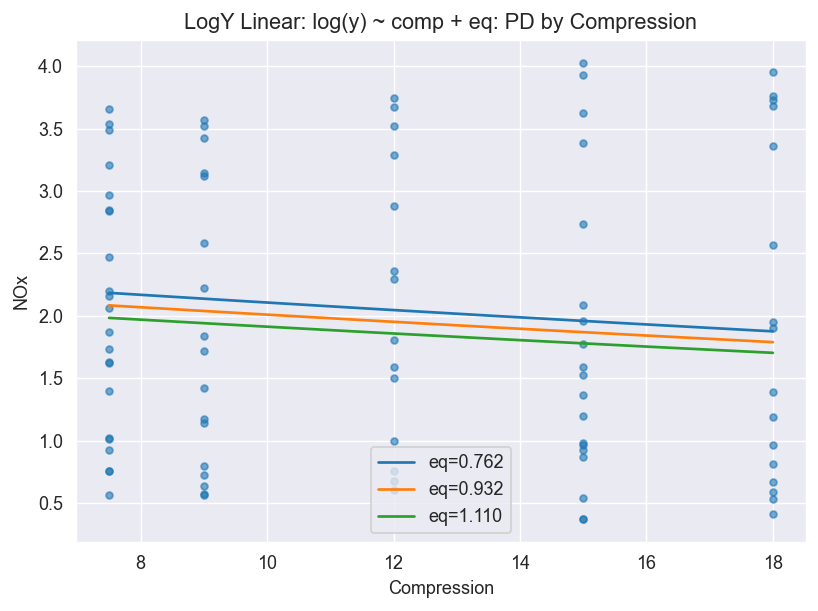

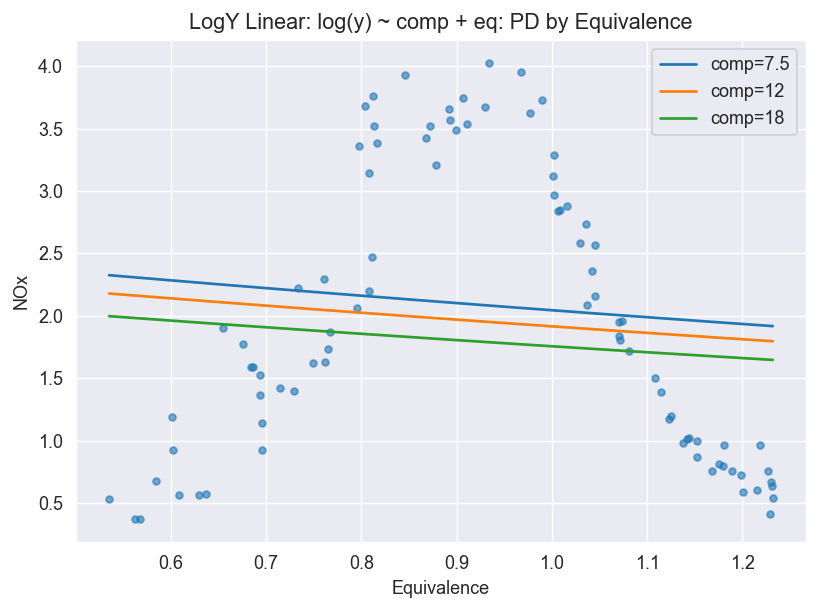

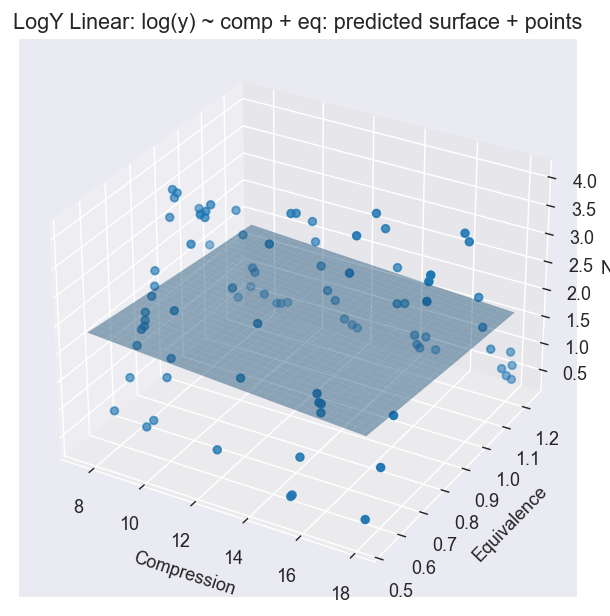

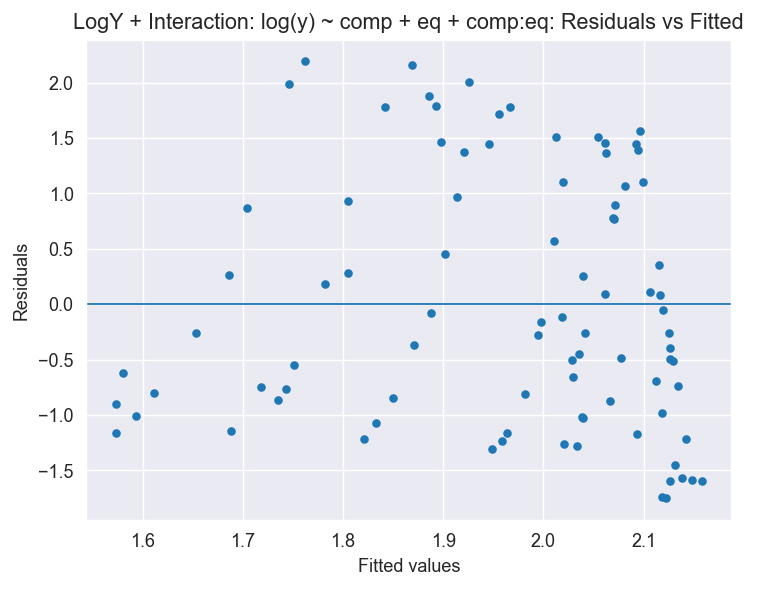

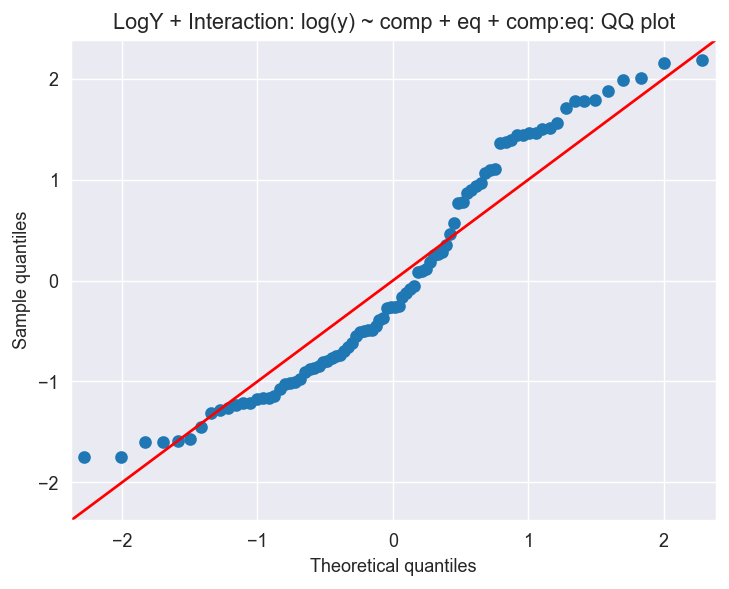

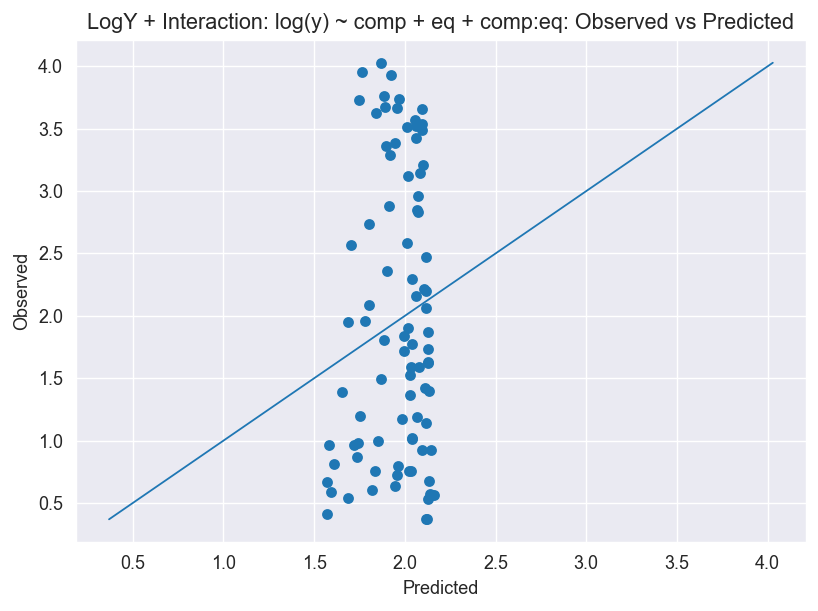

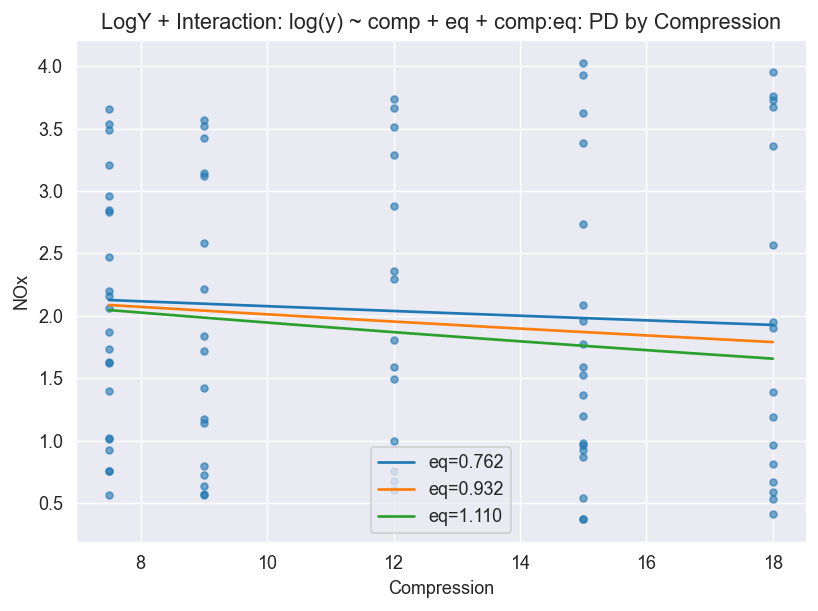

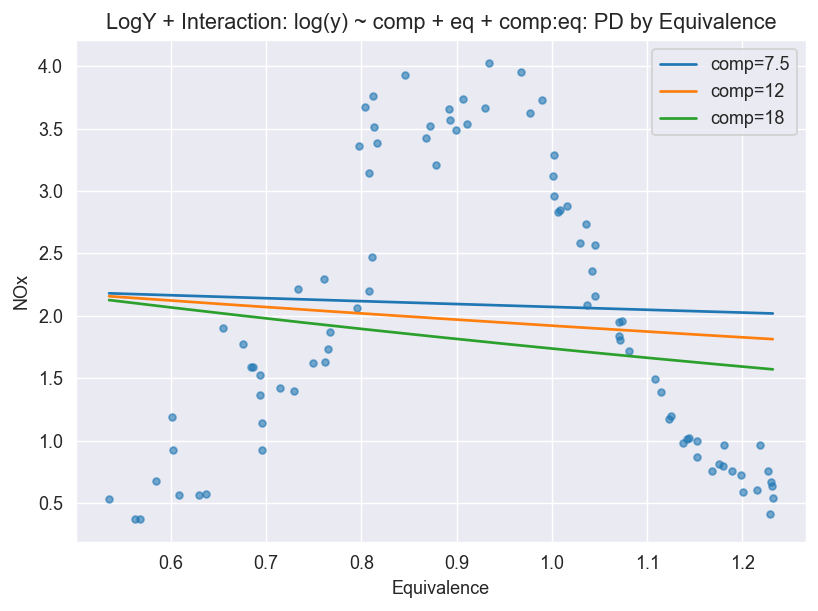

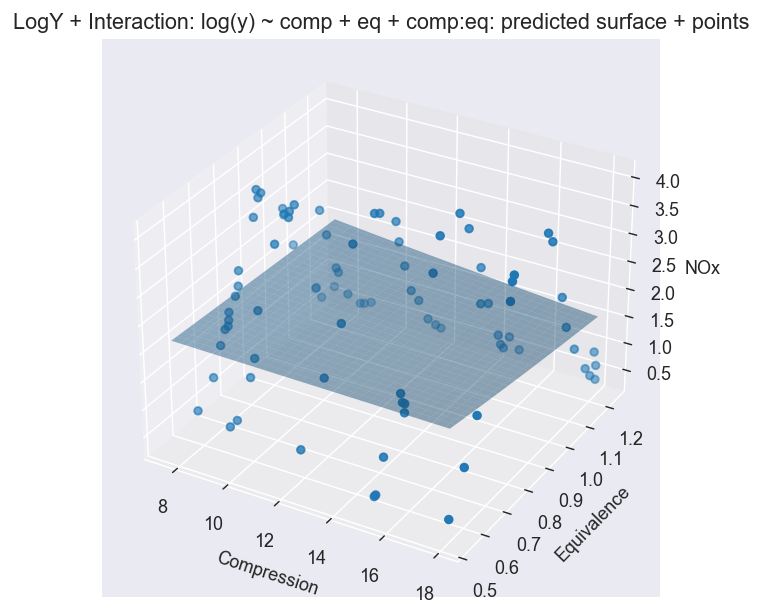


Сравнение моделей:
                                                        model        AIC        BIC  R2(transf.)     RESET p2     RESET p3     BP p     AD p  R2_orig     RMSE      MAE  smearing
Quadratic (full 2nd): y ~ comp + eq + comp^2 + eq^2 + comp:eq 115.165972 130.029993     0.850929 3.352047e-21 4.640634e-20 0.480965 0.000155 0.850929 0.434844 0.385158       NaN
                              LogY Linear: log(y) ~ comp + eq 183.708716 191.140726     0.015087 2.700396e-04 1.289105e-03 0.037950 0.000042 0.001101 1.125635 0.977719  1.218538
             LogY + Interaction: log(y) ~ comp + eq + comp:eq 185.590407 195.499754     0.016410 1.094466e-08 4.077810e-11 0.053811 0.000067 0.002968 1.124583 0.977589  1.217855
                                        Linear: y ~ comp + eq 275.690180 283.122191     0.010953 1.777929e-25 6.212107e-27 0.030105 0.000017 0.010953 1.120071 0.977277       NaN
                  Linear+Interaction: y ~ comp + eq + comp:eq 277.514179 287.423527     0.

In [30]:
Path("out").mkdir(parents=True, exist_ok=True)

df = read_any("V1/Ethanol.txt") 
data = df[["NOx","Compression","Equivalence"]].apply(pd.to_numeric, errors="coerce").dropna()
data = data.rename(columns={"NOx":"y","Compression":"comp","Equivalence":"eq"})



# === 1) Utils ===
def reg_metrics(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    sse = np.sum((y - yhat)**2); sst = np.sum((y - y.mean())**2)
    return {
        "R2_orig": 1 - sse/sst,
        "RMSE": np.sqrt(sse / y.size),
        "MAE": np.mean(np.abs(y - yhat)),
    }

def duan_smearing(yhat_log, resid_log):
    s = float(np.mean(np.exp(resid_log)))
    return np.exp(yhat_log) * s, s

def make_X(name, comp, eq):
    comp = np.asarray(comp, float); eq = np.asarray(eq, float)
    if name == "lin":
        X = np.column_stack([comp, eq])
    elif name == "lin_int":
        X = np.column_stack([comp, eq, comp*eq])
    elif name == "quad2":
        X = np.column_stack([comp, eq, comp**2, eq**2, comp*eq])
    else:
        raise ValueError("unknown design")
    return sm.add_constant(X, has_constant="add")

def fit_model(label, design, y_tf=None, inv_y=None):
    x = data["comp"].values; z = data["eq"].values; y = data["y"].values
    y_t = y_tf(y) if y_tf else y
    X = make_X(design, x, z)

    res = sm.OLS(y_t, X).fit()
    yhat_t = res.predict(X)
    if inv_y is None:
        yhat = yhat_t
        smear = None
    else:
        yhat, smear = duan_smearing(yhat_t, res.resid)

    # resid
    plot_residuals(y_true=y, y_pred=yhat, title=label,
                   save_prefix=f"out/ethanol_{label.replace(' ','_')}")

    bp = het_breuschpagan(y - yhat, X)  # (LM, p_LM, F, p_F)
    ad = normal_ad(y - yhat)            # (stat, p)
    reset2 = linear_reset(res, power=2, use_f=True)
    reset3 = linear_reset(res, power=3, use_f=True)
    # p-values
    def _p(v): 
        try: return float(v.pvalue)
        except: return float(v[1])

    # scatter: Data vs Model
    fig = plt.figure()
    plt.scatter(yhat, y, s=25)
    mn, mx = min(y.min(), yhat.min()), max(y.max(), yhat.max())
    plt.plot([mn, mx], [mn, mx], lw=1)
    plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.title(f"{label}: Observed vs Predicted")
    fig.tight_layout(); fig.savefig(f"out/ethanol_{label.replace(' ','_')}_obs_vs_pred.png", dpi=130, bbox_inches="tight"); plt.show()


    # PD by comp; eq = const
    eq_levels = np.quantile(z, [0.25, 0.5, 0.75])
    comp_grid = np.linspace(x.min(), x.max(), 200)
    fig = plt.figure()
    for q in eq_levels:
        Xg = make_X(design, comp_grid, np.full_like(comp_grid, q))
        yg_t = res.predict(Xg)
        yg = yg_t if inv_y is None else np.exp(yg_t) * float(np.mean(np.exp(res.resid)))
        plt.plot(comp_grid, yg, label=f"eq={q:.3f}")
    plt.scatter(x, y, s=14, alpha=0.6)
    plt.xlabel("Compression"); plt.ylabel("NOx"); plt.title(f"{label}: PD by Compression")
    plt.legend(); fig.tight_layout()
    fig.savefig(f"out/ethanol_{label.replace(' ','_')}_pd_comp.png", dpi=130, bbox_inches="tight"); plt.show()

    # PD by eq;  comp = const (min/med/max)
    comp_levels = [x.min(), np.median(x), x.max()]
    eq_grid = np.linspace(z.min(), z.max(), 200)
    fig = plt.figure()
    for c in comp_levels:
        Xg = make_X(design, np.full_like(eq_grid, c), eq_grid)
        yg_t = res.predict(Xg)
        yg = yg_t if inv_y is None else np.exp(yg_t) * float(np.mean(np.exp(res.resid)))
        plt.plot(eq_grid, yg, label=f"comp={c:g}")
    plt.scatter(z, y, s=14, alpha=0.6)
    plt.xlabel("Equivalence"); plt.ylabel("NOx"); plt.title(f"{label}: PD by Equivalence")
    plt.legend(); fig.tight_layout()
    fig.savefig(f"out/ethanol_{label.replace(' ','_')}_pd_eq.png", dpi=130, bbox_inches="tight"); plt.show()

    # 3D-model
    from mpl_toolkits.mplot3d import Axes3D
    C = np.linspace(x.min(), x.max(), 60)
    E = np.linspace(z.min(), z.max(), 60)
    CC, EE = np.meshgrid(C, E)
    Xs = make_X(design, CC.ravel(), EE.ravel())
    ysurf_t = res.predict(Xs).reshape(CC.shape)
    ysurf = ysurf_t if inv_y is None else np.exp(ysurf_t) * float(np.mean(np.exp(res.resid)))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(CC, EE, ysurf, alpha=0.45, linewidth=0)
    ax.scatter(x, z, y, s=18)
    ax.set_xlabel("Compression"); ax.set_ylabel("Equivalence"); ax.set_zlabel("NOx")
    ax.set_title(f"{label}: predicted surface + points")
    fig.tight_layout()
    fig.savefig(f"out/ethanol_{label.replace(' ','_')}_surface3d.png", dpi=130, bbox_inches="tight"); plt.show()

    return {
        "model": label,
        "AIC": res.aic, "BIC": res.bic, "R2_transf": res.rsquared,
        "RESET_p2": _p(reset2), "RESET_p3": _p(reset3),
        "BP_p": float(bp[3]), "AD_p": float(ad[1]),
        "metrics_orig": reg_metrics(y, yhat),
        "smearing": smear, "res": res
    }

results = []
results.append(fit_model("Linear: y ~ comp + eq", design="lin"))
results.append(fit_model("Linear+Interaction: y ~ comp + eq + comp:eq", design="lin_int"))
results.append(fit_model("Quadratic (full 2nd): y ~ comp + eq + comp^2 + eq^2 + comp:eq", design="quad2"))
results.append(fit_model("LogY Linear: log(y) ~ comp + eq", design="lin", y_tf=np.log, inv_y=np.exp))
results.append(fit_model("LogY + Interaction: log(y) ~ comp + eq + comp:eq", design="lin_int", y_tf=np.log, inv_y=np.exp))

# === out ===
tbl = pd.DataFrame([{
    "model": r["model"],
    "AIC": r["AIC"], "BIC": r["BIC"], "R2(transf.)": r["R2_transf"],
    "RESET p2": r["RESET_p2"], "RESET p3": r["RESET_p3"],
    "BP p": r["BP_p"], "AD p": r["AD_p"],
    "R2_orig": r["metrics_orig"]["R2_orig"],
    "RMSE": r["metrics_orig"]["RMSE"],
    "MAE": r["metrics_orig"]["MAE"],
    "smearing": r["smearing"] if r["smearing"] is not None else np.nan
} for r in results]).sort_values(["AIC","BIC"])
print("\nСравнение моделей:")
print(tbl.to_string(index=False))
tbl.to_csv("out/ethanol_models_summary.csv", index=False)

# Топ-3 summary to file
with open("out/ethanol_top3.txt","w",encoding="utf-8") as f:
    for name in tbl.head(3)["model"]:
        rr = next(r for r in results if r["model"] == name)
        f.write("="*80 + "\n" + name + "\n" + "="*80 + "\n")
        f.write(str(rr["res"].summary()) + "\n\n")

